# Описание данных
Таблица rest_data:
- id — идентификатор объекта;
- object_name — название объекта общественного питания;
- chain — сетевой ресторан;
- object_type — тип объекта общественного питания;
- address — адрес;
- number — количество посадочных мест.


# План работы

- Изучить файлы с данными.
- Проверить данные на пропуски, дубликаты.
- Провести предобработку данных.
- Построить графики.
- Исследовать соотношение видов объектов общественного питания по количеству, соотношение сетевых и несетевых заведений по количеству.
- Определить  для какого вида объекта общественного питания характерно сетевое распространение.
- Определить что характерно для сетевых заведений: много заведений с небольшим числом посадочных мест в каждом или мало заведений с большим количеством посадочных мест?
- Описать среднее количество посадочных мест.
- Построить график топ-10 улиц по количеству объектов общественного питания.
- Найти число улиц с одним объектом общественного питания.	
- Определить распределение количества посадочных мест для улиц с большим количеством объектов общественного питания.

## Ознакомление с данными

In [1]:
import pandas as pd
import numpy as np

import math
from scipy import stats

import seaborn as sns
from matplotlib import pyplot as plt

from pymystem3 import Mystem
from collections import Counter
import re

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('/datasets/rest_data.csv')
data.head()

,id,object_name,chain,object_type,address,number
0,151635,СМЕТАНА,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48
1,77874,Родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35
2,24309,Кафе «Академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95
3,21894,ПИЦЦЕТОРИЯ,да,кафе,"город Москва, Абрамцевская улица, дом 1",40
4,119365,Кафе «Вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50


In [3]:
data['object_name'] = data['object_name'].str.lower()
data['address'] = data['address'].str.lower()

In [4]:
sns.set(palette='mako', context='talk',style='darkgrid')

In [5]:
def check(data):
    data.info()
    nan_perc = data.isna().sum() / data.shape[0] * 100
    print()
    print('Индекс упорядочен:',data.index.is_monotonic)
    print('Кол-во дубликатов -',data.duplicated().sum())
    print()
    print('\033[1mКол-во пропусков:\033[0m')
    print(data.isna().sum())
    print()
    print('\033[1mПроцент пропусков:\033[0m')
    print(nan_perc.sort_values(ascending=False))
    print('---------------------------')
    for column in data.columns:
        print()
        print('\033[1mCтолбец\033[0m', column)
        print('Кол-во уникальных значений -',data[column].nunique())
        print('Кол-во пропусков -',data[column].isnull().sum())
        print('Кол-во дубликатов -', data[column].duplicated().sum())
        print()
        print(data[column].value_counts().head())
        print()

In [6]:
check(data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15366 entries, 0 to 15365
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           15366 non-null  int64 
 1   object_name  15366 non-null  object
 2   chain        15366 non-null  object
 3   object_type  15366 non-null  object
 4   address      15366 non-null  object
 5   number       15366 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 720.4+ KB

Индекс упорядочен: True
Кол-во дубликатов - 0

Кол-во пропусков:
id             0
object_name    0
chain          0
object_type    0
address        0
number         0
dtype: int64

Процент пропусков:
id             0.0
object_name    0.0
chain          0.0
object_type    0.0
address        0.0
number         0.0
dtype: float64
---------------------------

Cтолбец id
Кол-во уникальных значений - 15366
Кол-во пропусков - 0
Кол-во дубликатов - 0

163840    1
207007    1
58806     1
198074    1
150035    1
Nam

In [7]:
data['object_type'].unique()

array(['кафе', 'столовая', 'закусочная',
       'предприятие быстрого обслуживания', 'ресторан', 'кафетерий',
       'буфет', 'бар', 'магазин (отдел кулинарии)'], dtype=object)

In [8]:
data['object_type'] = data['object_type'].str.replace('предприятие быстрого обслуживания','фаст-фуд')

In [9]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
id,15366.0,119720.066901,73036.130732,838.0,28524.0,144974.5,184262.25,223439.0
number,15366.0,59.547182,74.736833,0.0,12.0,40.0,80.00,1700.0


In [10]:
print('Кол-во заведений без посадочных мест:',data[data['number'] == 0]['number'].count())
print('Доля заведений без посадочных мест:', round(data[data['number'] == 0]['number'].count()/ len(data) * 100, 2))

Кол-во заведений без посадочных мест: 1621
Доля заведений без посадочных мест: 10.55


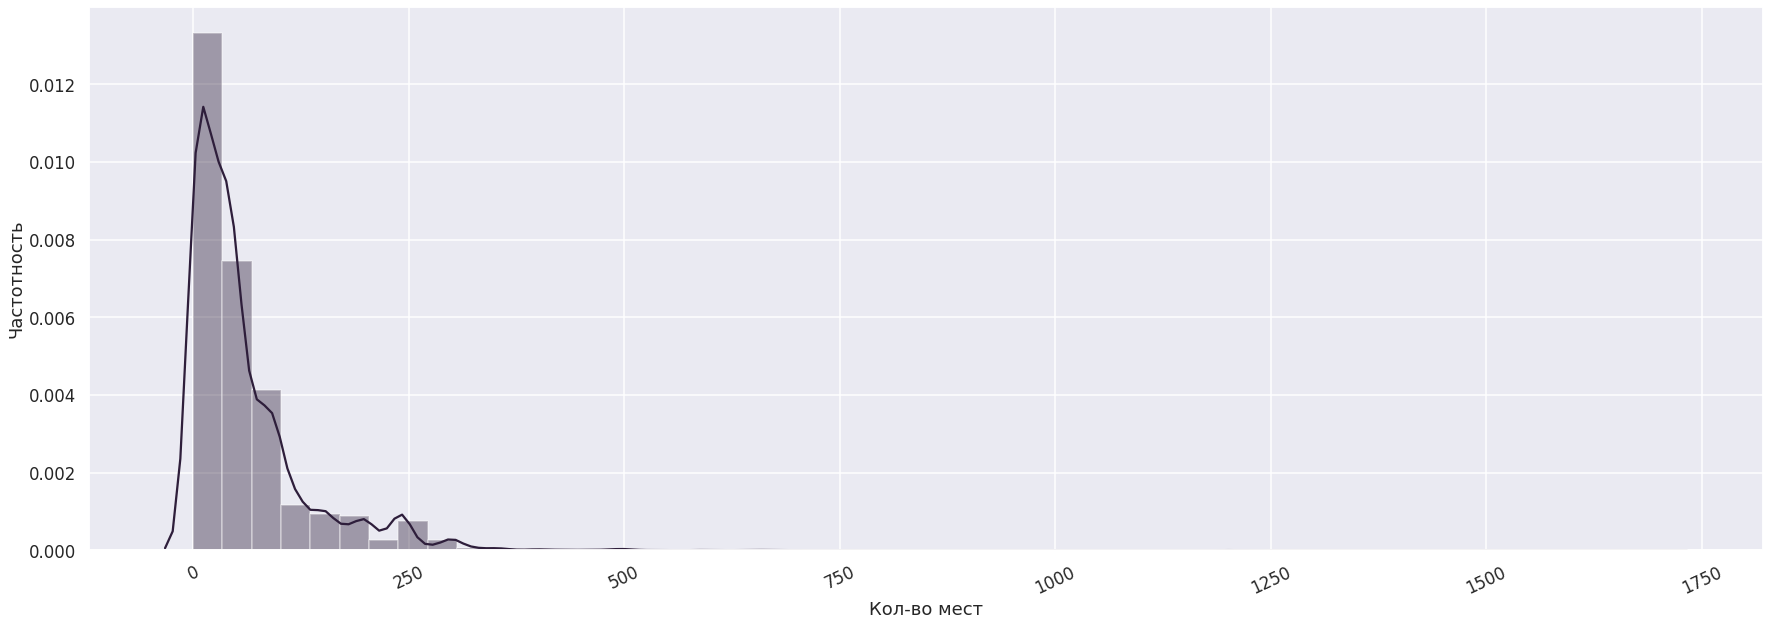

In [11]:
plt.figure(figsize=(30,10))
sns.distplot(data['number'])
plt.title('', size='xx-large')
plt.xlabel('Кол-во мест')
plt.ylabel('Частотность')
plt.xticks(rotation=25)
plt.show()

In [12]:
print('Кол-во заведений с больше 200 посадочных мест:', data[data['number'] > 200]['number'].count())
print('Доля заведений с больше 200 посадочных мест:', round(data[data['number'] > 200]['number'].count()/ len(data) * 100, 2))

Кол-во заведений с больше 200 посадочных мест: 799
Доля заведений с больше 200 посадочных мест: 5.2


### Вывод

- У нас данные состоят из 15363 строк уникальных id.
- Пропуски и дубликаты отсутствуют. 
- Все типы данных в порядке.
- Привели к нижнему регистру типы объектов питания и адреса улиц.
- Изменили название типа объекта «предприятие быстрого обслуживания» на «фаст-фуд».
- Кол-во заведений без посадочных мест: 1621, примерно 11% от всех объектов.
- Также, видим, что в основном кол-во посадочных мест до 200. А кол-во заведений посадочных больше двухсот мест: 799, это 5%. Уберем эти данные и не будем их учитывать в анализе.

## Анализ данных

### Исследуйте соотношение видов объектов общественного питания по количеству. Постройте график.

In [13]:
data = data[data['number'] <= 200]

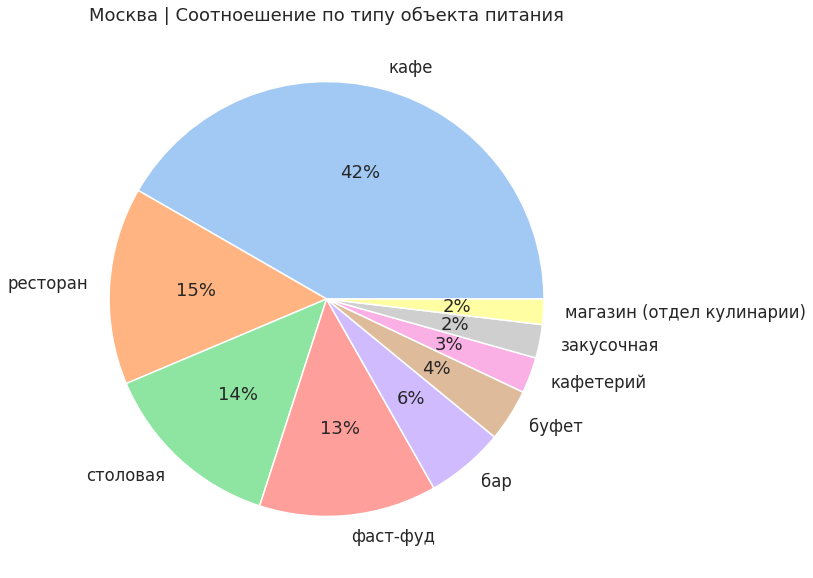

In [87]:
labels = data['object_type'].value_counts().index
values = data['object_type'].value_counts().to_list()

colors = sns.color_palette('pastel')

# create pie chart using matplotlib
plt.figure(figsize=(10,10))
plt.title('Москва | Соотноешение по типу объекта питания')
plt.pie(values, labels=labels, colors=colors, autopct='%.0f%%')
plt.show()

In [15]:
data['object_type'].value_counts().head()

кафе        6055
ресторан    2128
столовая    2027
фаст-фуд    1913
бар          849
Name: object_type, dtype: int64

**Промежуточные выводы:** Видим, что на рынке общественного питания преобладают «кафе» — 42% (6055 заведения), далее «ресторан — 15% (2128), «столовая» — 14% (2027), «фаст-фуд» — 13% (1913), остальные виды объектов ниже 6%. 

### Исследуйте соотношение сетевых и несетевых заведений по количеству. Постройте график.

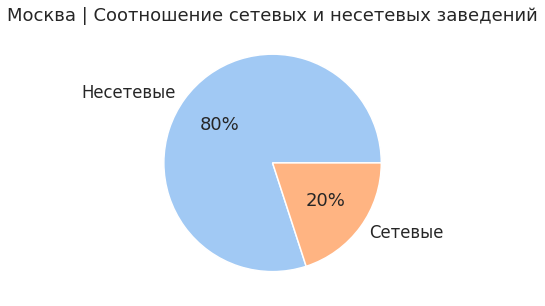

In [85]:
labels = ['Несетевые', 'Сетевые']
values = data['chain'].value_counts()
colors = sns.color_palette('pastel')

# create pie chart using matplotlib
plt.figure(figsize=(10,5))
plt.title('Москва | Соотношение сетевых и несетевых заведений')
plt.pie(values, labels=labels, colors=colors, autopct='%.0f%%')
plt.show()

In [17]:
data['chain'].value_counts()

нет    11665
да      2902
Name: chain, dtype: int64

**Промежуточные выводы:** Видим, что всего 20% (2 902 объекта) сетевых заведений. Большинство несетевые объекты общественного питания - 80% (11 665 объекта)

### Для какого вида объекта общественного питания характерно сетевое распространение?


In [18]:
two_chainz = data.groupby(['object_type','chain'])['chain'].count()
two_chainz.name = 'count'
two_chainz = two_chainz.reset_index()

two_chainz.head()

,object_type,chain,count
0,бар,да,37
1,бар,нет,812
2,буфет,да,11
3,буфет,нет,554
4,закусочная,да,56


In [19]:
yes_chain = two_chainz[two_chainz['chain']== 'да'].sort_values(by='count', ascending=False)
yes_chain.head()

,object_type,chain,count
6,кафе,да,1379
16,фаст-фуд,да,781
12,ресторан,да,505
10,магазин (отдел кулинарии),да,78
4,закусочная,да,56


In [20]:
no_chain = two_chainz[two_chainz['chain']== 'нет'].sort_values(by='count', ascending=False)
no_chain.head()

,object_type,chain,count
7,кафе,нет,4676
15,столовая,нет,2024
13,ресторан,нет,1623
17,фаст-фуд,нет,1132
1,бар,нет,812


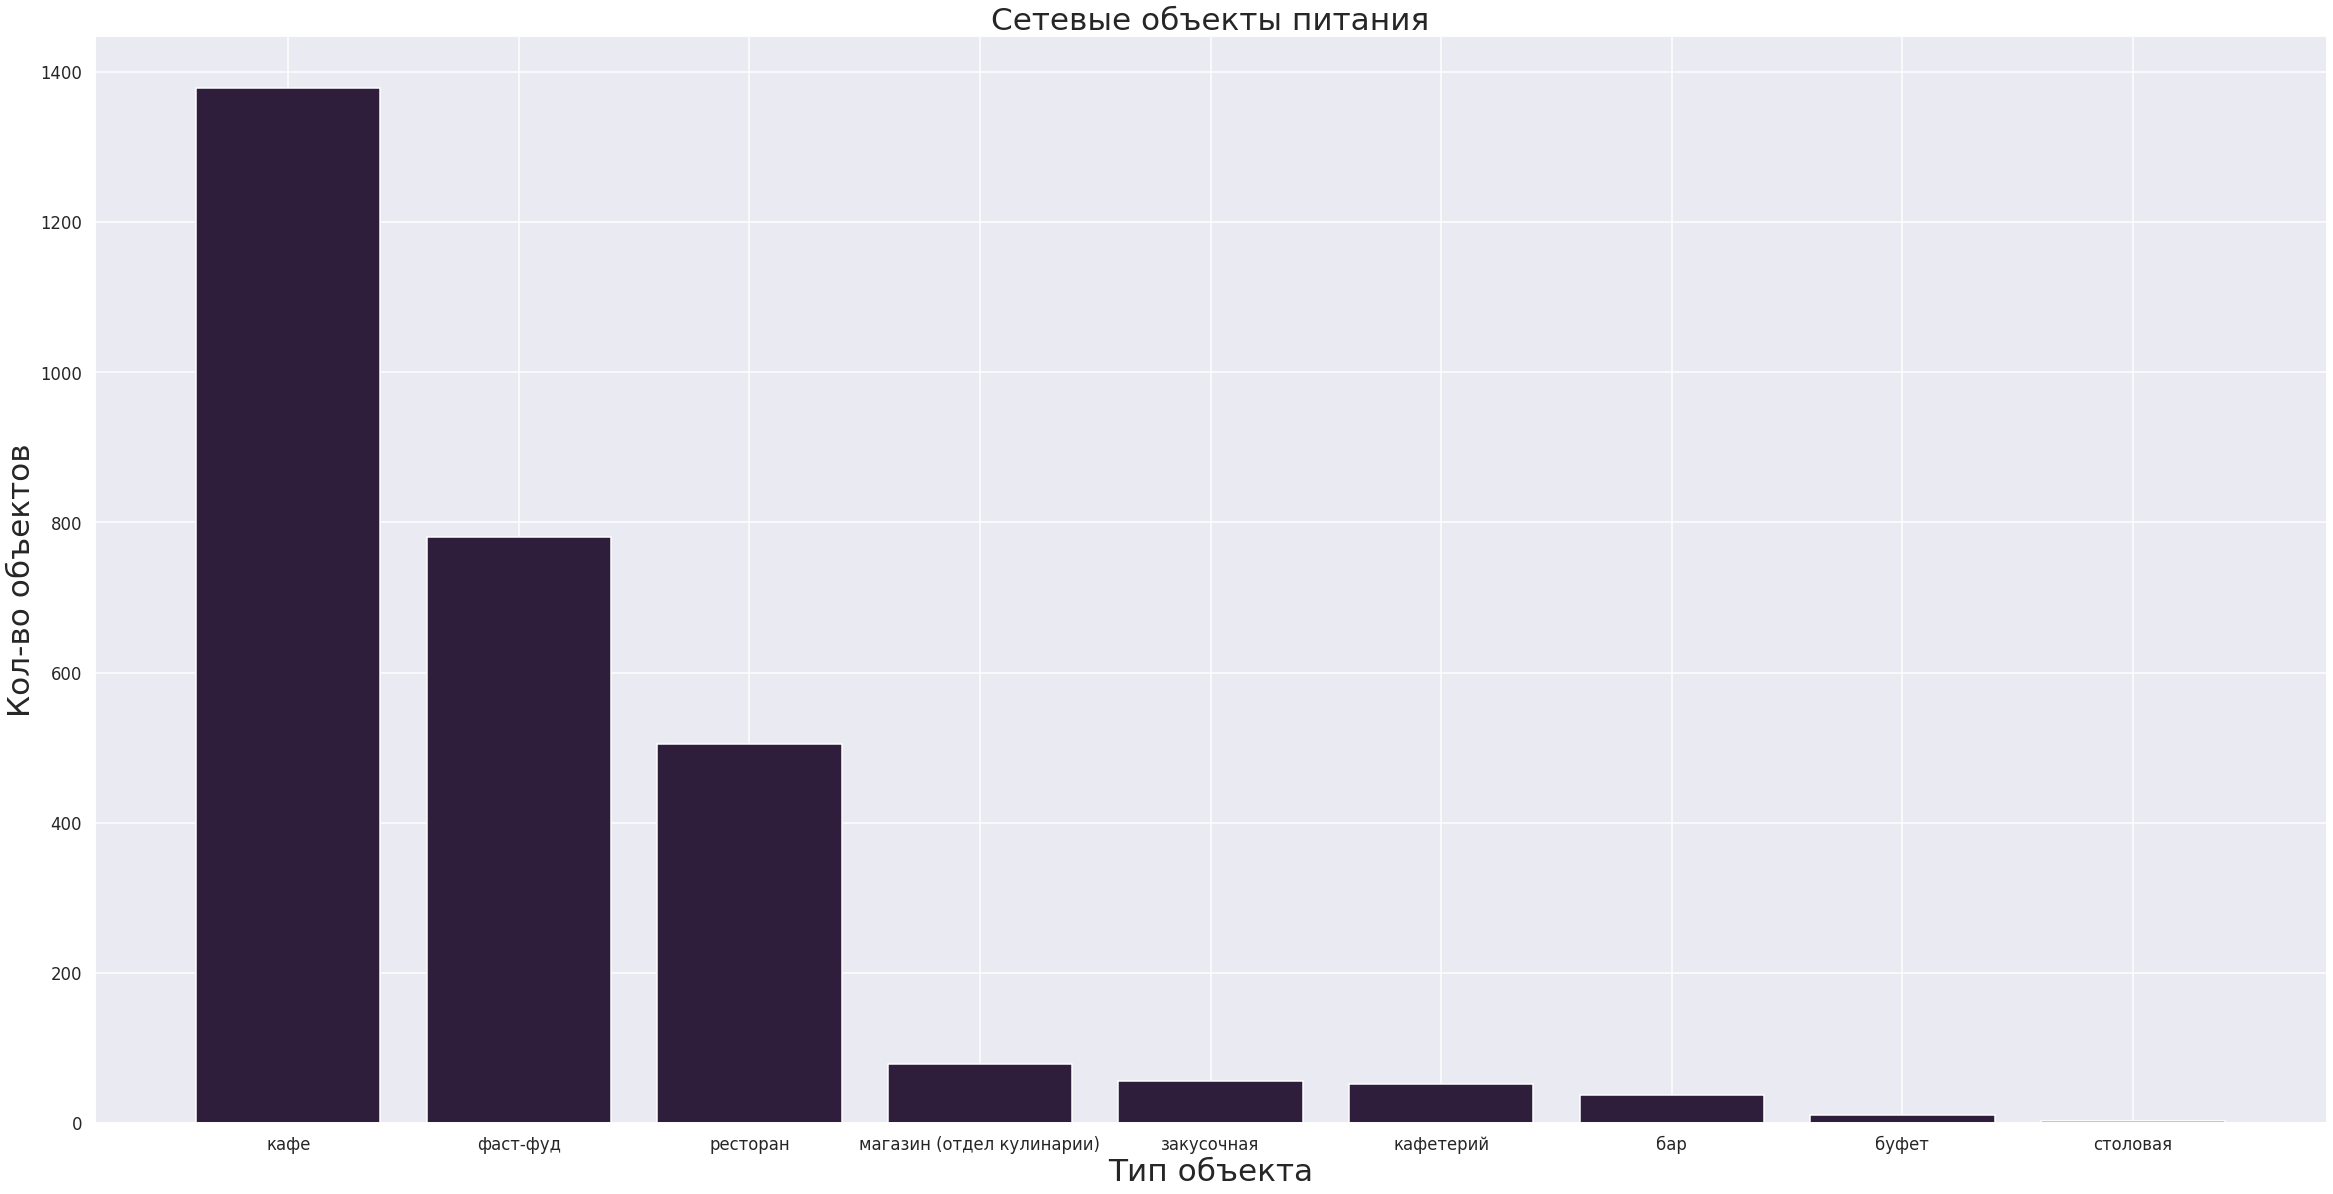

In [21]:
plt.figure(figsize=(40,20))
plt.title('Сетевые объекты питания', size='xx-large')
plt.ylabel('Кол-во объектов',size='xx-large')
plt.xlabel('Тип объекта', size='xx-large')
plt.bar(x=yes_chain['object_type'], height=yes_chain['count'])
plt.show()

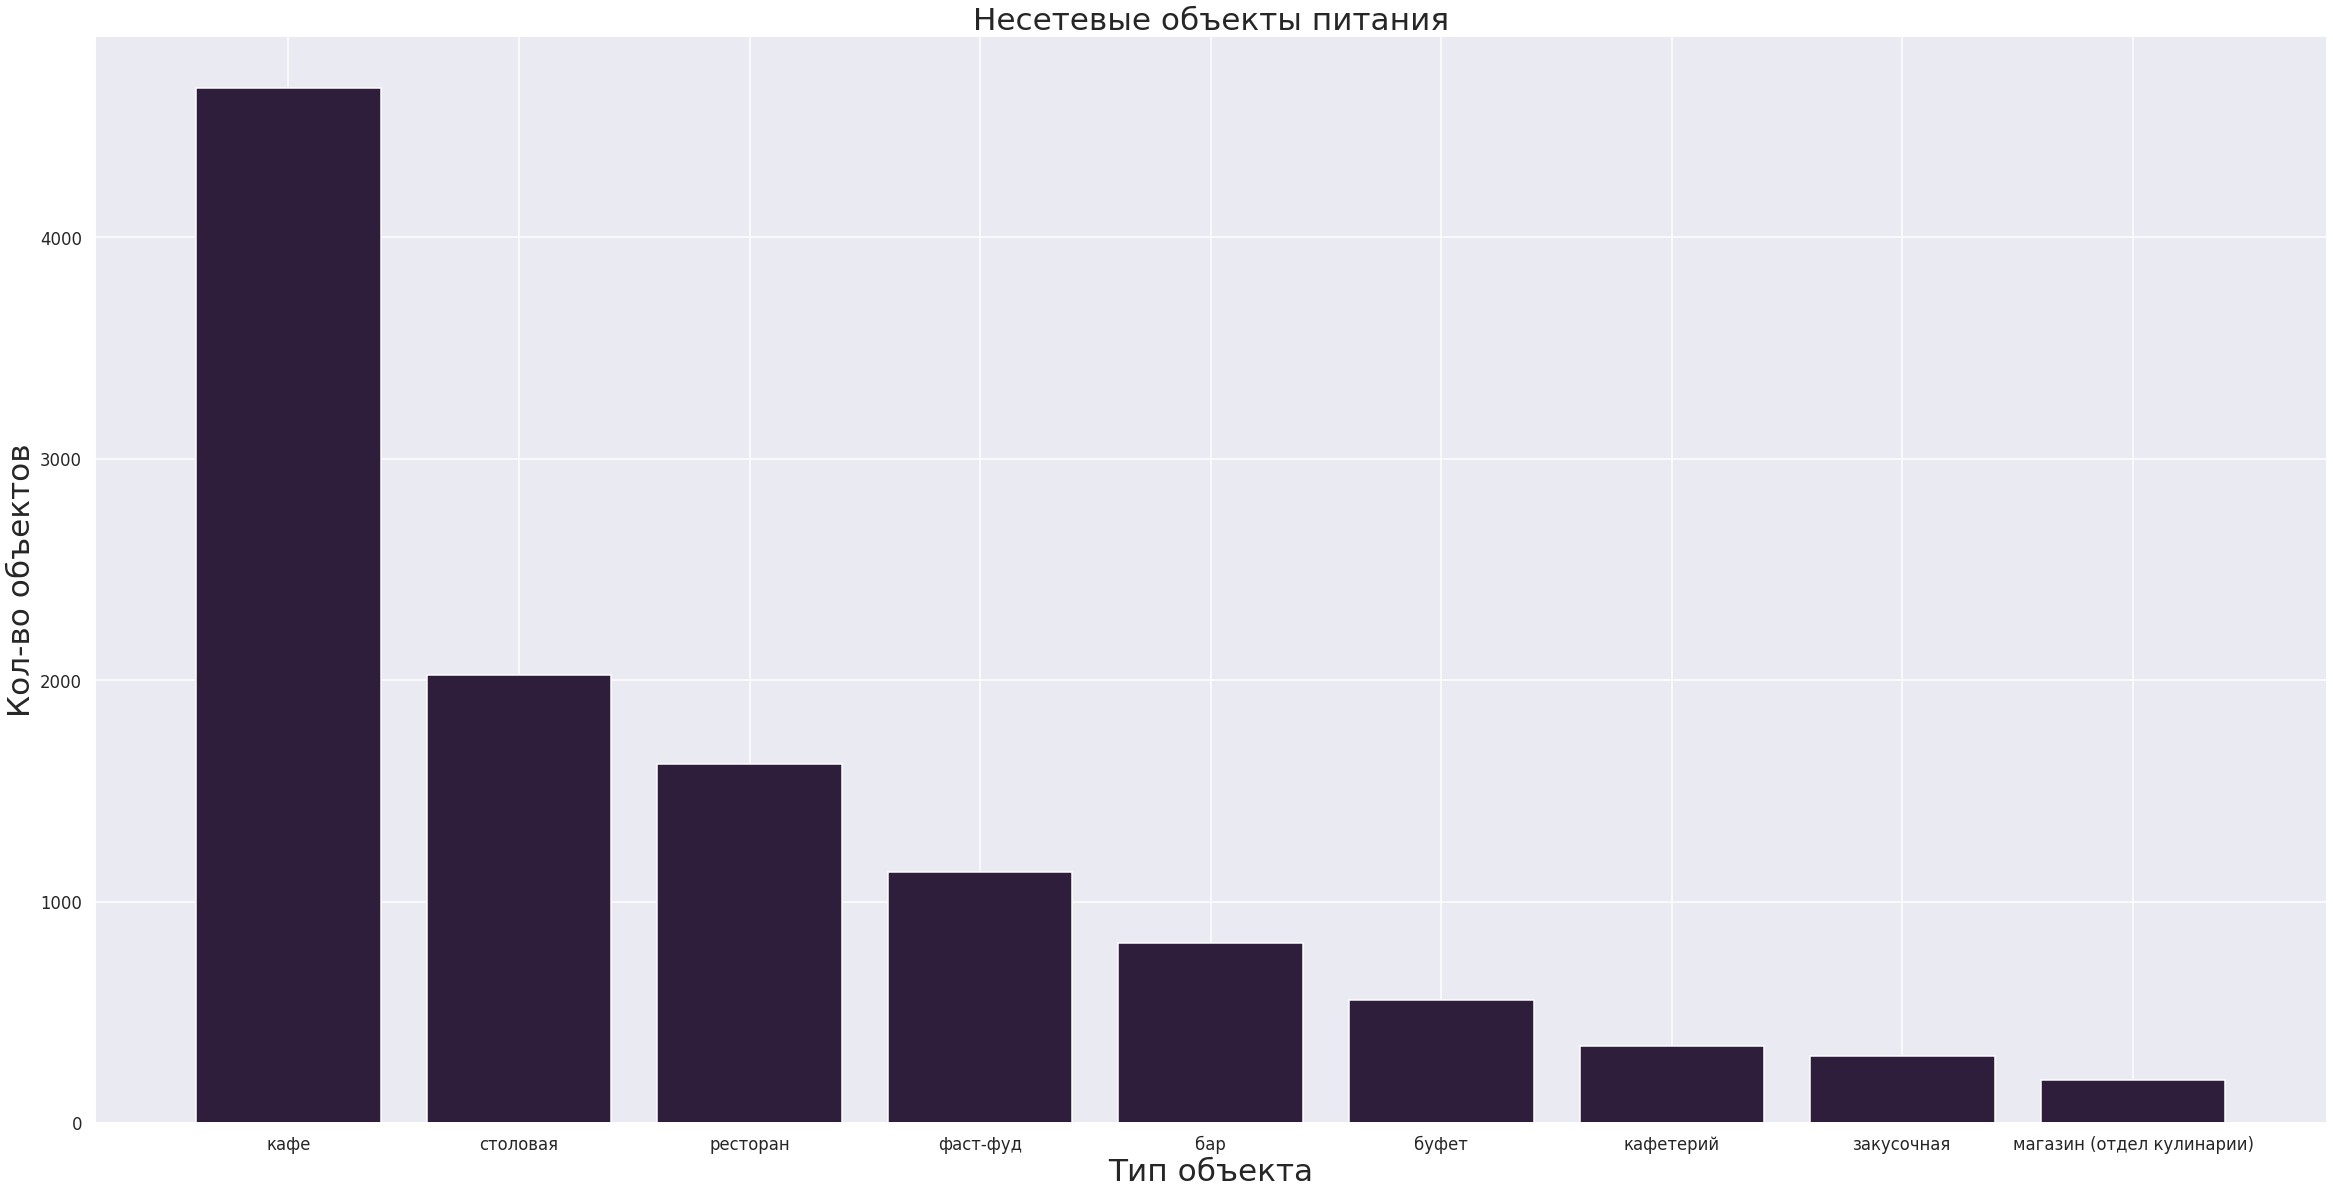

In [22]:
plt.figure(figsize=(40,20))
plt.title('Несетевые объекты питания', size='xx-large')
plt.ylabel('Кол-во объектов',size='xx-large')
plt.xlabel('Тип объекта', size='xx-large')
plt.bar(x=no_chain['object_type'], height=no_chain['count'])
plt.show()

In [23]:
yes_chain.tail(1)

,object_type,chain,count
14,столовая,да,3


**Промежуточные вывод:** Видим, что для сетевых характерны: Кафе, Фас-фуд и Рестораны. Интересно, что сетевых столовых всего 3. А в случае с несетевыми объектами тройка лидеров меняет на: Кафе, Столовая и Ресторан.

#### Доля сетевых

In [24]:
share = two_chainz.groupby('object_type')['count'].sum().reset_index()
share.columns = ['object_type','object_count']
yes_chain = yes_chain.merge(share, on='object_type', how='left')
yes_chain['share'] = ((yes_chain['count'] / yes_chain['object_count']) * 100).round(2)

yes_chain = yes_chain.sort_values(by='share', ascending=False)
yes_chain

,object_type,chain,count,object_count,share
1,фаст-фуд,да,781,1913,40.83
3,магазин (отдел кулинарии),да,78,273,28.57
2,ресторан,да,505,2128,23.73
0,кафе,да,1379,6055,22.77
4,закусочная,да,56,359,15.60
5,кафетерий,да,52,398,13.07
6,бар,да,37,849,4.36
7,буфет,да,11,565,1.95
8,столовая,да,3,2027,0.15


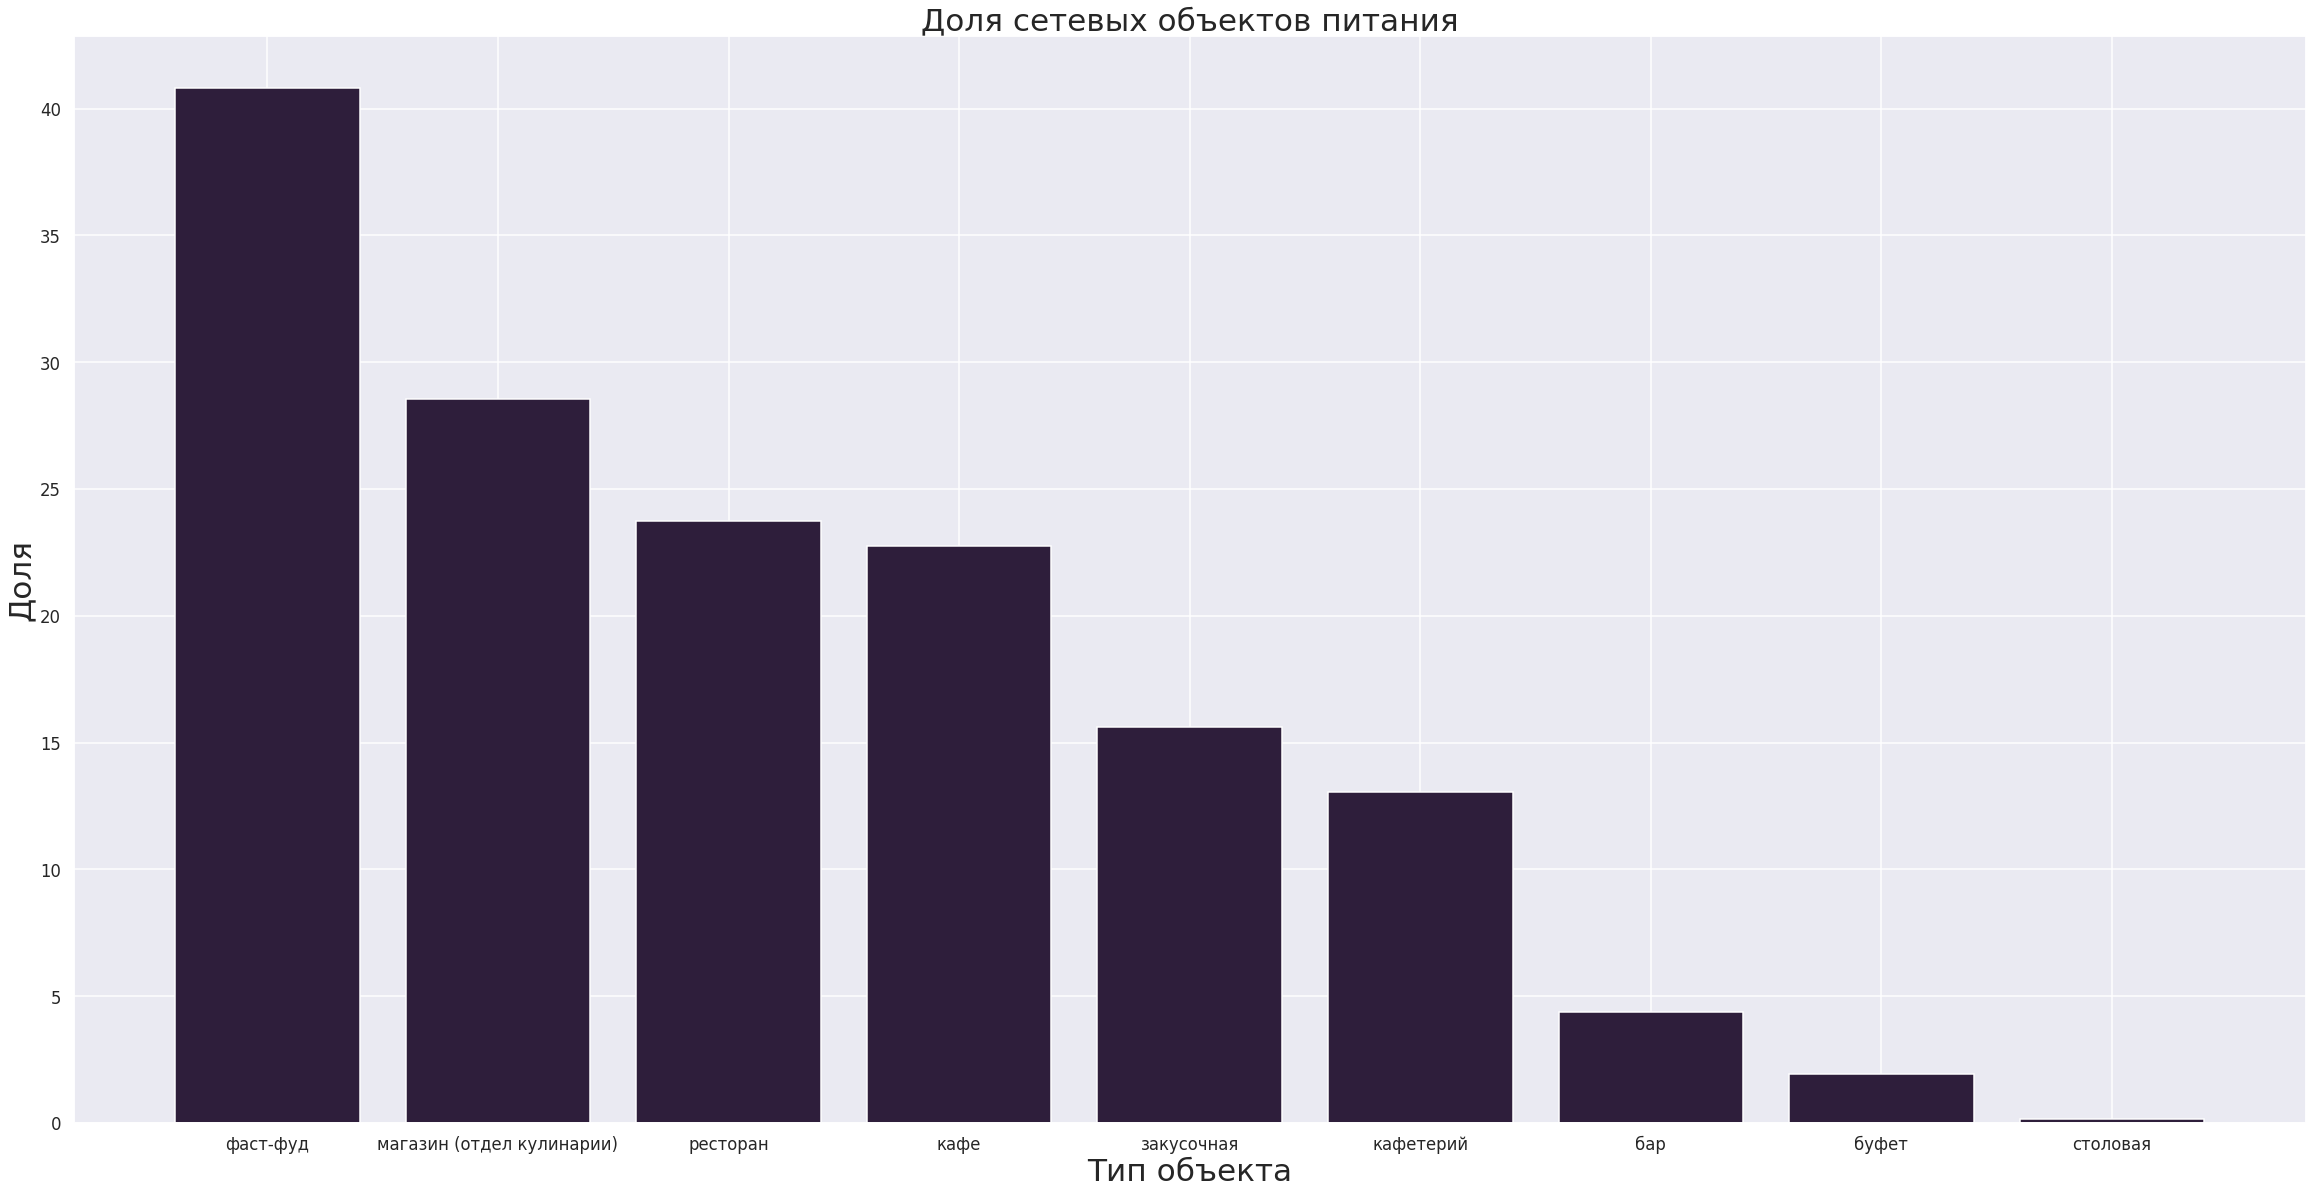

In [25]:
plt.figure(figsize=(40,20))
plt.title('Доля сетевых объектов питания', size='xx-large')
plt.ylabel('Доля',size='xx-large')
plt.xlabel('Тип объекта', size='xx-large')
plt.bar(x=yes_chain['object_type'], height=yes_chain['share'])
plt.show()

#### Доля несетевых

In [26]:
no_chain = no_chain.merge(share, on='object_type', how='left')
no_chain['share'] = ((no_chain['count'] / no_chain['object_count']) * 100).round(2)
no_chain = no_chain.sort_values(by='share', ascending=False)

no_chain

,object_type,chain,count,object_count,share
1,столовая,нет,2024,2027,99.85
5,буфет,нет,554,565,98.05
4,бар,нет,812,849,95.64
6,кафетерий,нет,346,398,86.93
7,закусочная,нет,303,359,84.40
0,кафе,нет,4676,6055,77.23
2,ресторан,нет,1623,2128,76.27
8,магазин (отдел кулинарии),нет,195,273,71.43
3,фаст-фуд,нет,1132,1913,59.17


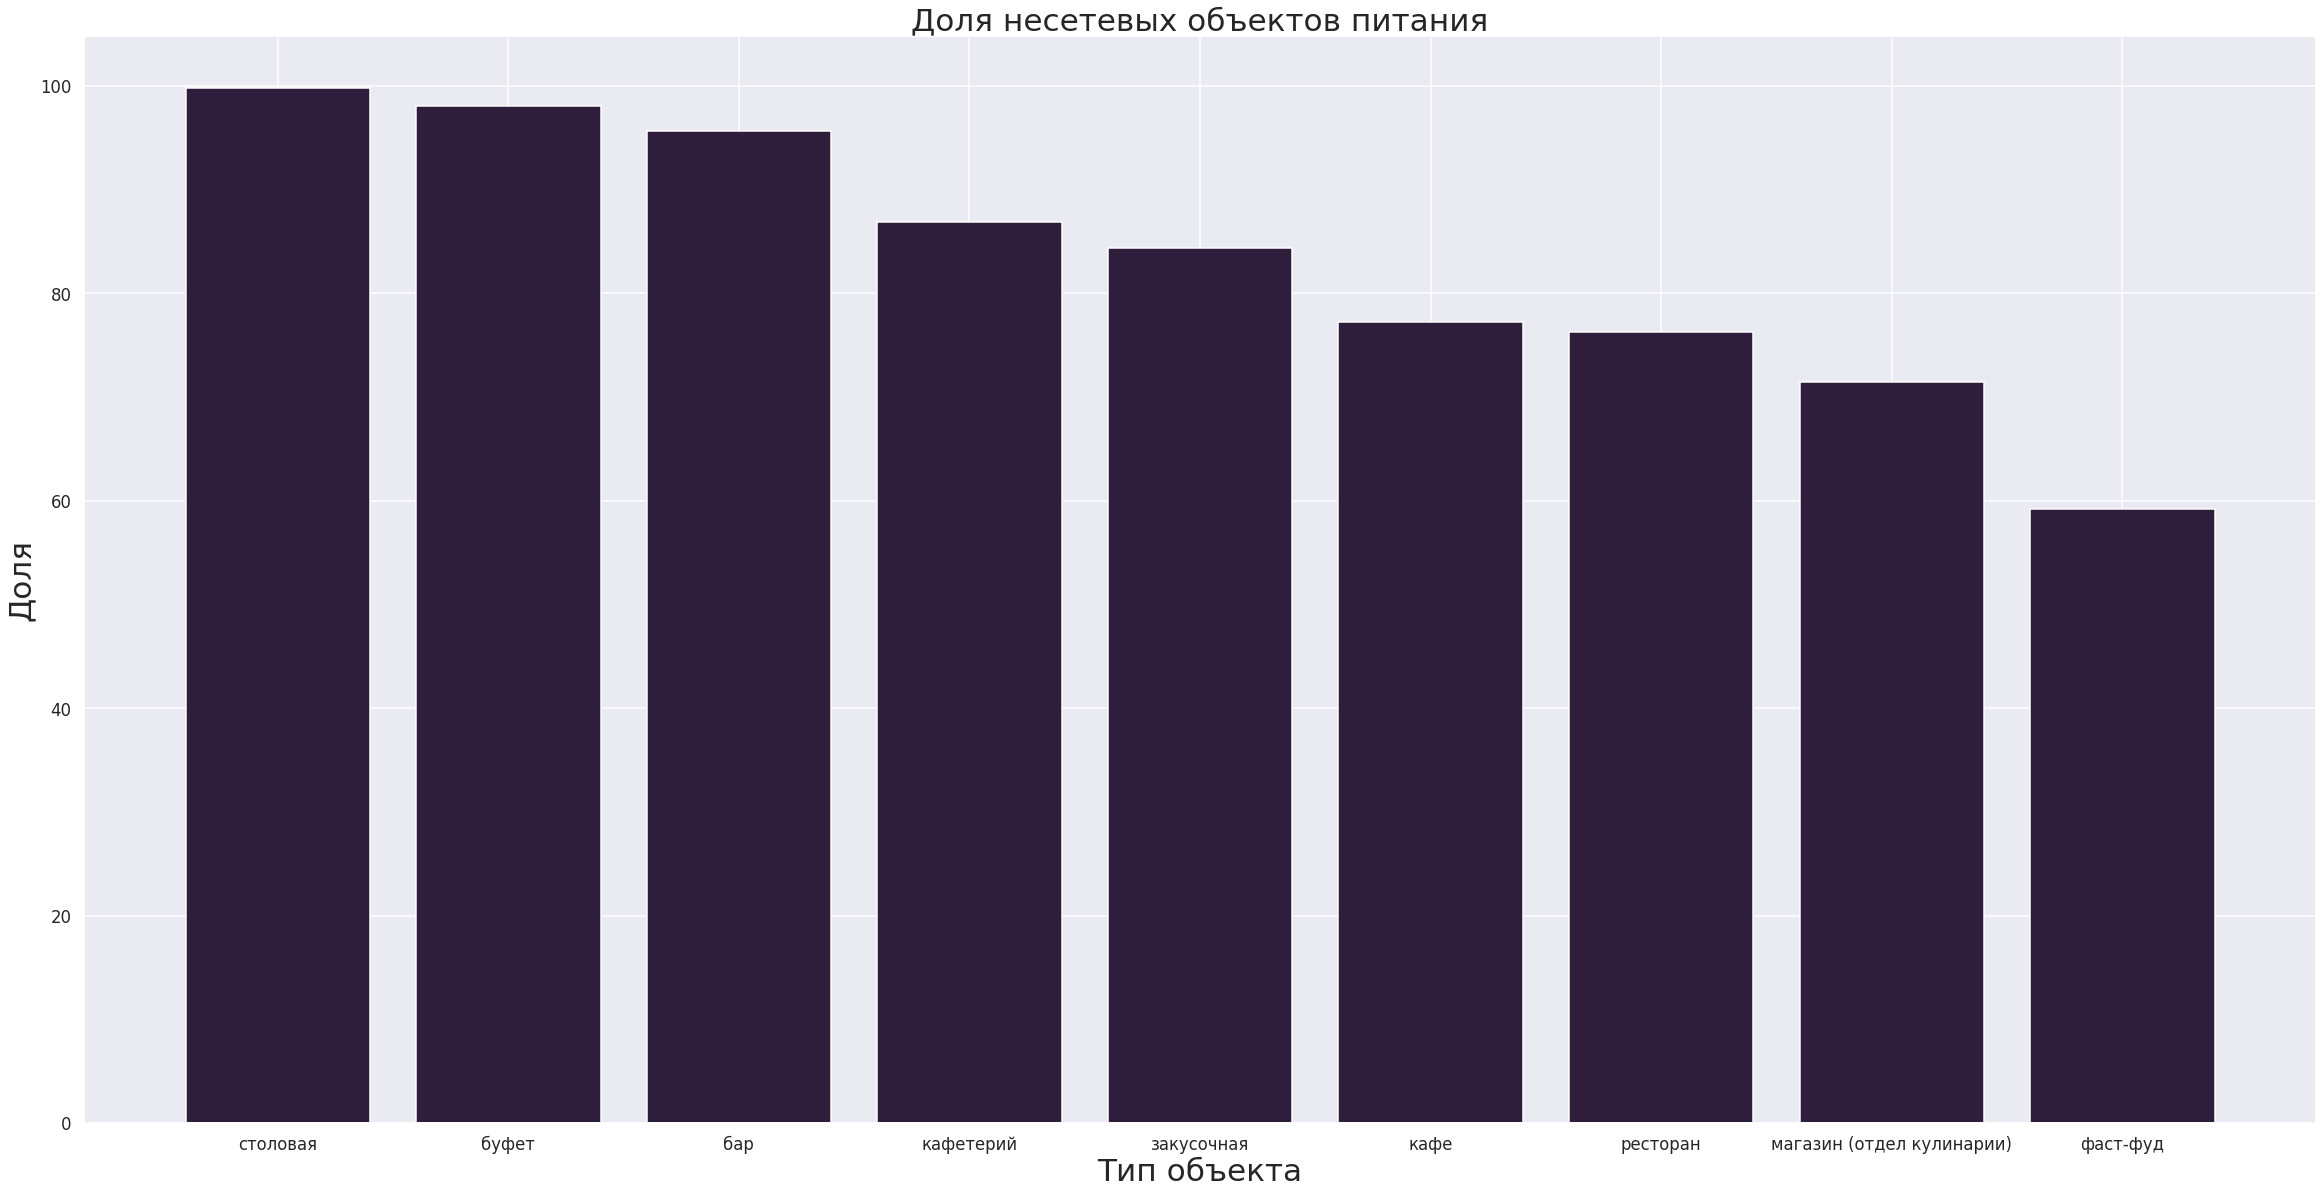

In [27]:
plt.figure(figsize=(40,20))
plt.title('Доля несетевых объектов питания', size='xx-large')
plt.ylabel('Доля',size='xx-large')
plt.xlabel('Тип объекта', size='xx-large')
plt.bar(x=no_chain['object_type'], height=no_chain['share'])
plt.show()

**Промежуточные вывод:** В доле сетевых предприятий видим явного лидера — заведения типа Фаст-фуд — 40% и почти с одинаково распределись: Магазин (кулинария) — 28%, Ресторан — 23%, Бар— 22%.

###  Что характерно для сетевых заведений: много заведений с небольшим числом посадочных мест в каждом или мало заведений с большим количеством посадочных мест?


In [28]:
yes = data[(data['number'] != 0) & (data['chain'] == 'да')]
no = data[(data['chain']== 'нет') & (data['number'] != 0)]

#### Сетевые

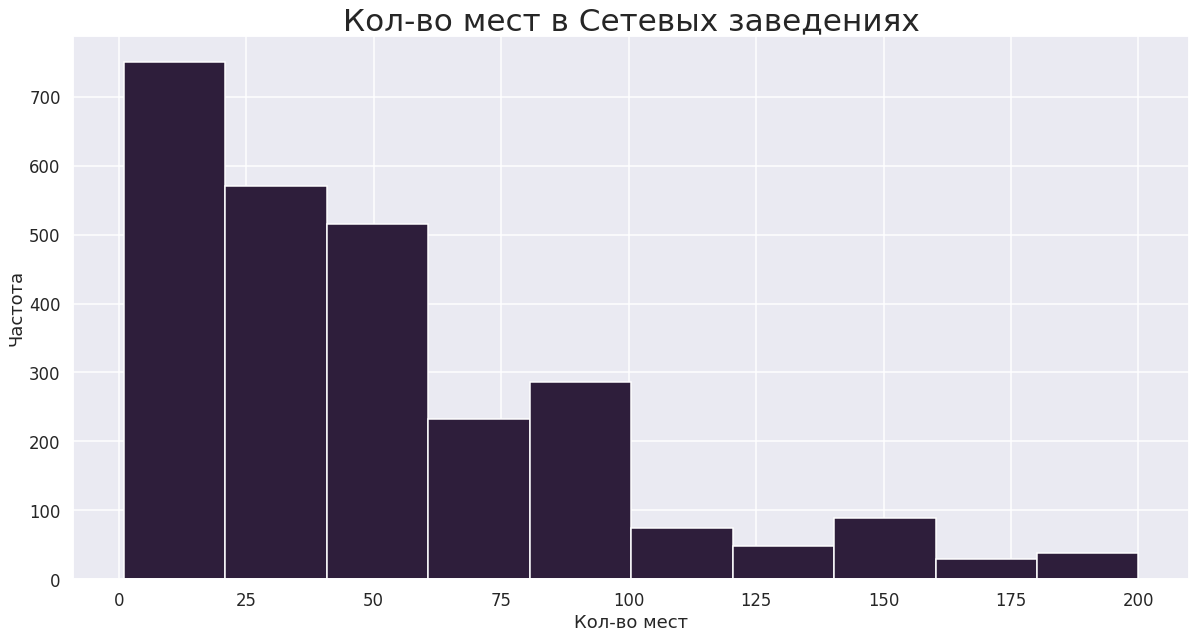

In [29]:
plt.figure(figsize=(20,10))
plt.title('Кол-во мест в Сетевых заведениях', size='xx-large')
plt.ylabel('Частота')
plt.xlabel('Кол-во мест')
plt.hist(yes['number'])
plt.show()

#### Несетевые

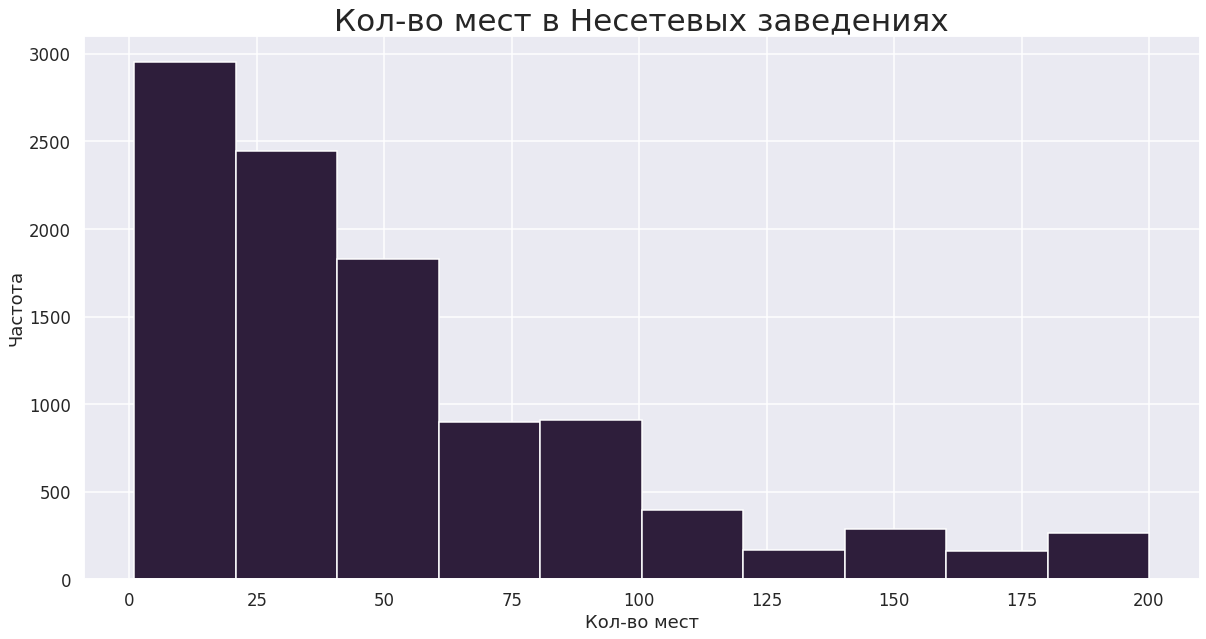

In [30]:
plt.figure(figsize=(20,10))
plt.title('Кол-во мест в Несетевых заведениях', size='xx-large')
plt.ylabel('Частота')
plt.xlabel('Кол-во мест')
plt.hist(no['number'])
plt.show()

**Промежуточный вывод:** Как в случае с сетевыми, так и в случае с несетевыми, видно, что характерны общие черты. Много заведений с относительно маленьким кол-вом мест. По графику, что заведений, которые имеют больше 100 посадочных мест значительно меньше в обоих случаях.

### Для каждого вида объекта общественного питания опишите среднее количество посадочных мест. Какой вид предоставляет в среднем самое большое количество посадочных мест? Постройте графики.


#### Сетевые

In [79]:
mean_yes = yes.groupby('object_type').agg({'id':'count', 'number':'mean'}).round(2)
mean_yes = mean_yes.sort_values(by='number',ascending=False)
mean_yes

,id,number
object_type,,
столовая,3,112.33
ресторан,487,88.69
бар,36,54.50
буфет,3,46.67
кафе,1324,46.49
фаст-фуд,661,43.33
закусочная,38,21.18
кафетерий,37,17.24
магазин (отдел кулинарии),45,15.04


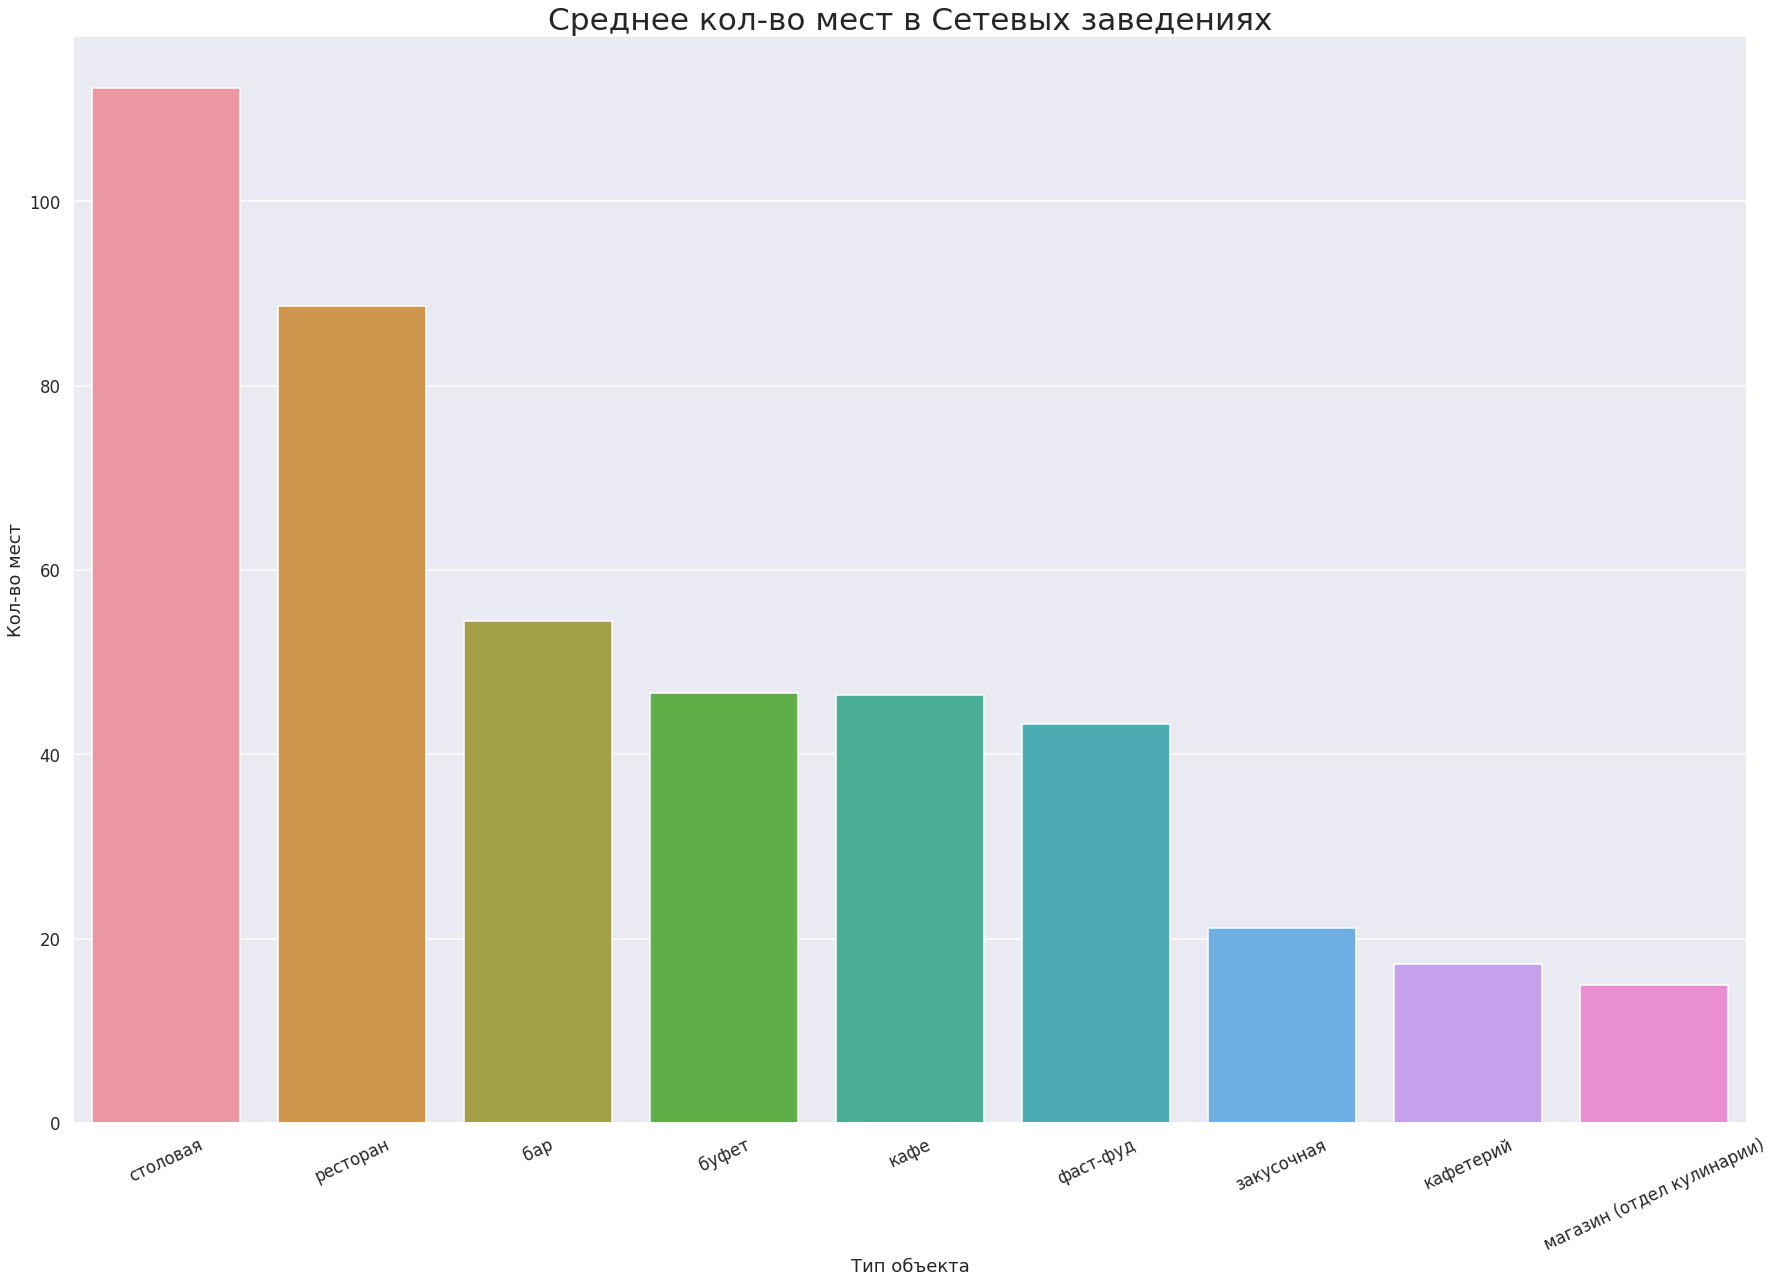

In [80]:
plt.figure(figsize=(30,20))
sns.barplot(x='object_type', y='number', data=mean_yes.reset_index())
plt.title('Среднее кол-во мест в Сетевых заведениях', size='xx-large')
plt.xlabel('Тип объекта')
plt.ylabel('Кол-во мест')
plt.xticks(rotation=25)
plt.show()

In [81]:
yes.groupby(by='object_type')['number'].describe().sort_values(by='mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
object_type,,,,,,,,
столовая,3.0,112.333333,53.910420,55.0,87.5,120.0,141.0,162.0
ресторан,487.0,88.685832,48.946534,4.0,50.0,85.0,120.0,200.0
бар,36.0,54.500000,40.594511,3.0,26.5,45.0,82.5,150.0
буфет,3.0,46.666667,25.166115,20.0,35.0,50.0,60.0,70.0
кафе,1324.0,46.487160,35.922702,2.0,20.0,40.0,60.0,200.0
фаст-фуд,661.0,43.328290,37.630254,1.0,15.0,35.0,60.0,200.0
закусочная,38.0,21.184211,18.719632,2.0,8.0,18.0,33.5,91.0
кафетерий,37.0,17.243243,17.775460,1.0,8.0,10.0,20.0,85.0
магазин (отдел кулинарии),45.0,15.044444,13.731112,1.0,5.0,10.0,20.0,48.0


#### Несетевые

In [82]:
mean_no = no.groupby('object_type').agg({'id':'count', 'number':'mean'}).round(2)
mean_no = mean_no.sort_values(by='number',ascending=False)
mean_no

,id,number
object_type,,
столовая,2005,93.82
ресторан,1596,77.55
буфет,494,50.08
бар,785,40.84
кафе,4421,38.20
фаст-фуд,548,14.14
закусочная,132,13.02
кафетерий,248,12.07
магазин (отдел кулинарии),83,10.23


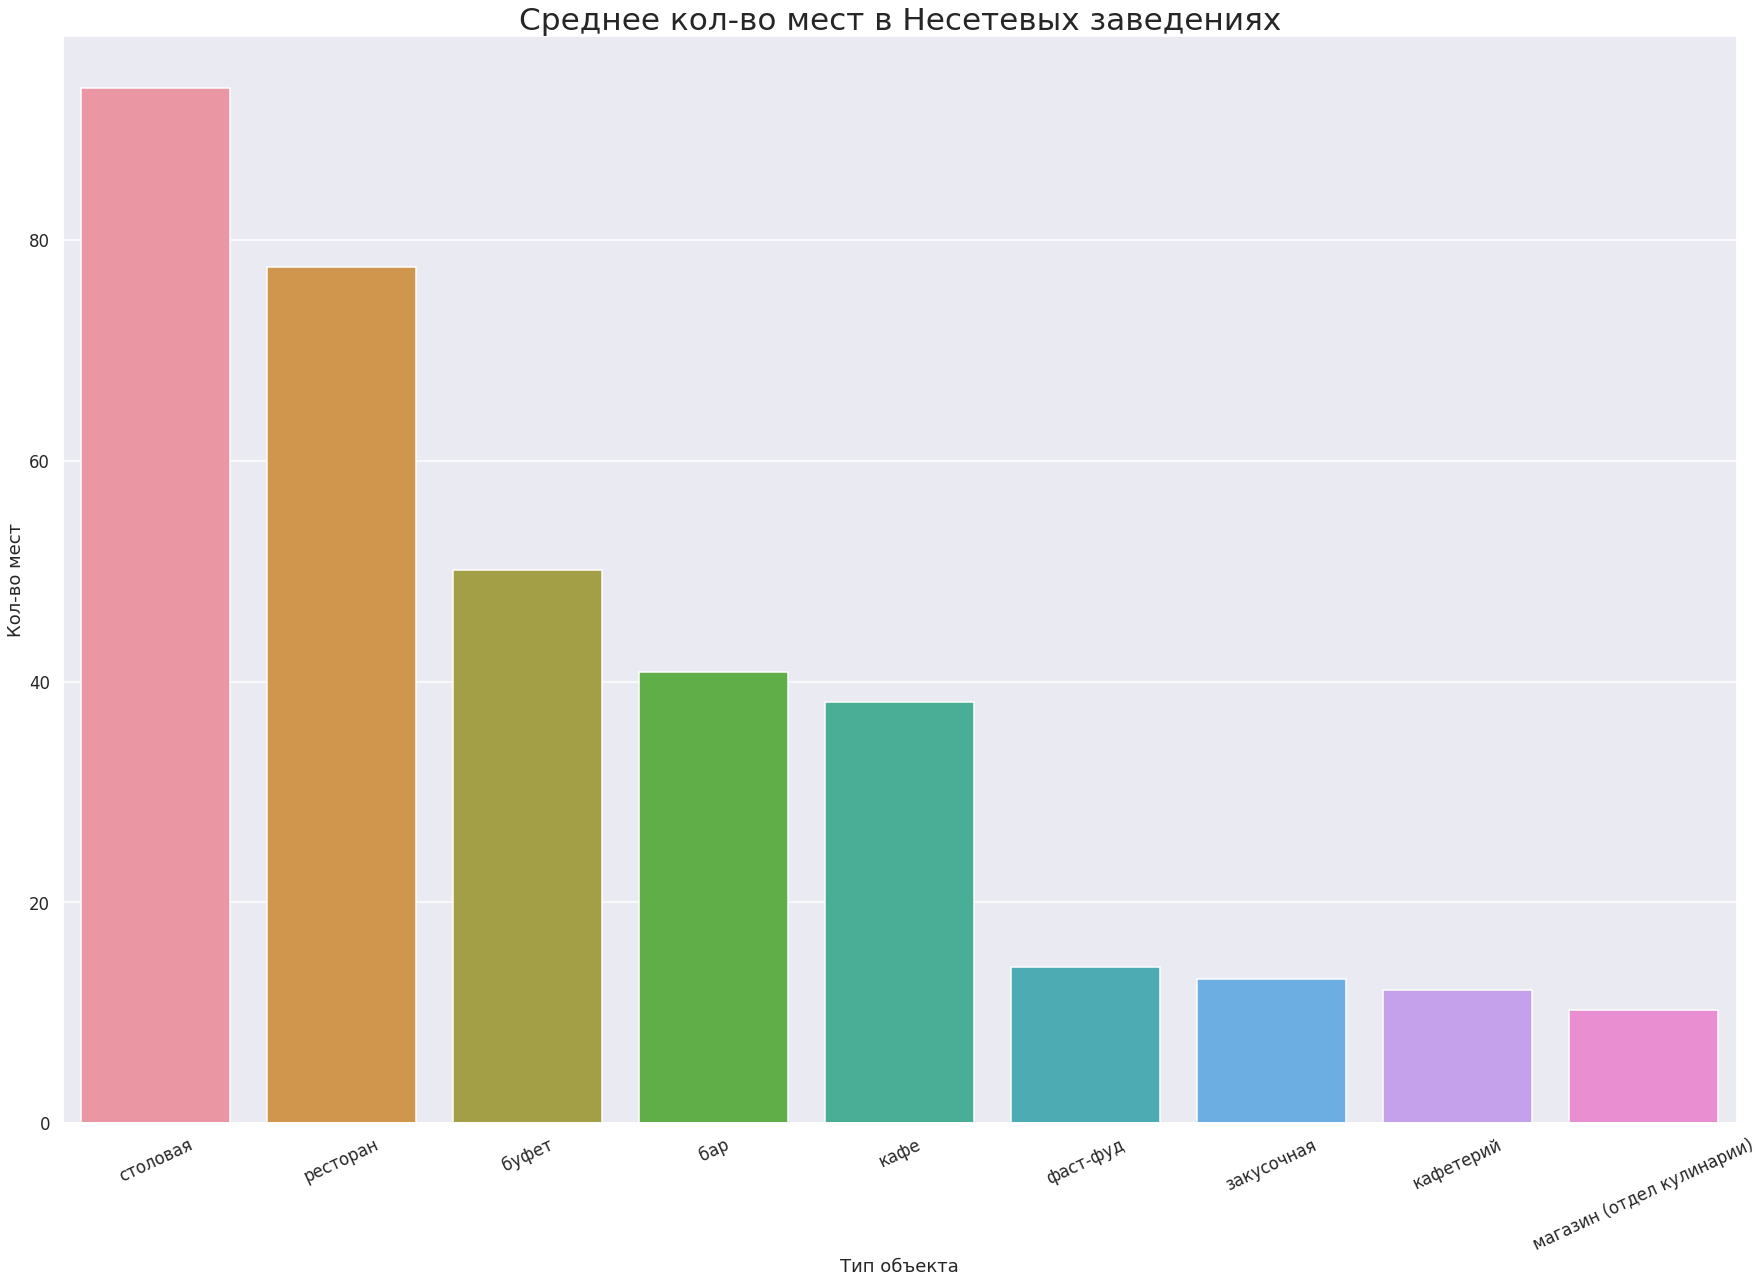

In [83]:
plt.figure(figsize=(30,20))
sns.barplot(x='object_type', y='number', data=mean_no.reset_index())
plt.title('Среднее кол-во мест в Несетевых заведениях', size='xx-large')
plt.xlabel('Тип объекта')
plt.ylabel('Кол-во мест')
plt.xticks(rotation=25)
plt.show()

In [84]:
no.groupby(by='object_type')['number'].describe().sort_values(by='mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
object_type,,,,,,,,
столовая,2005.0,93.819451,55.738441,1.0,47.0,80.0,134.0,200.0
ресторан,1596.0,77.547619,42.810477,2.0,45.0,70.0,98.0,200.0
буфет,494.0,50.080972,41.542392,1.0,20.0,36.0,80.0,200.0
бар,785.0,40.843312,30.356171,1.0,20.0,35.0,50.0,200.0
кафе,4421.0,38.203348,29.736315,1.0,16.0,32.0,48.0,200.0
фаст-фуд,548.0,14.142336,20.271237,1.0,4.0,8.0,16.0,200.0
закусочная,132.0,13.015152,12.762651,1.0,4.0,10.0,16.5,64.0
кафетерий,248.0,12.068548,15.547737,1.0,5.0,8.0,15.0,200.0
магазин (отдел кулинарии),83.0,10.228916,9.800853,1.0,3.5,6.0,13.0,50.0


**Промежуточные выводы:** В сетевых заведениях с наибольшим средним кол-вом посадочных мест лидирует Столовая — 112 мест, Ресторан — 88 мест, Бар — 54 места , а с наименьшим у Кафетерии — 17 мест, магазин (кулинария) — 15 мест.

В несетевых заведениях с наибольшим средним кол-вом посадочных мест лидирует Столовая — 93 мест, Ресторан — 77 мест, Буфет — 50 мест, а с наименьшим у Кафетерии — 12 мест, Магазин (кулинария) — 10 мест.

Видим, что первые два лидера и два аутсайдера не отличаются. Примерно на 20% в пользу сетевых заведений отличается среднее число посадочных мест.

### Выделите в отдельный столбец информацию об улице из столбца address.

In [37]:
m = Mystem() 
addresses = ' '.join(data['address'].unique())
lemmas = m.lemmatize(addresses)

In [38]:
words = ['улица','ул','переулок','шоссе','проспект','площадь','проезд', 'микрорайон', 'тупик', 'территория'
         'село','аллея','бульвар','набережная', 'зеленоград', 'капотня', 'километр'
         'тупик','линия', 'просек', 'поселение', 'деревня']

str_pat = r'.*,\s*\b([^,]*?(?:{})\b[^,]*)[,$]+'.format('|'.join(words))

data['street'] = data["address"].str.extract(str_pat, flags=re.I)

In [39]:
print('Пропусков в street:', data['street'].isna().sum())

Пропусков в street: 120


### Постройте график топ-10 улиц по количеству объектов общественного питания. Воспользуйтесь внешней информацией и ответьте на вопрос — в каких районах Москвы находятся эти улицы?

In [40]:
district = pd.read_csv('https://frs.noosphere.ru/xmlui/bitstream/handle/20.500.11925/714058/mosgaz-streets.csv')
district.head()

,streetname,areaid,okrug,area
0,Выставочный переулок,17,ЦАО,Пресненский район
1,улица Гашека,17,ЦАО,Пресненский район
2,Большая Никитская улица,17,ЦАО,Пресненский район
3,Глубокий переулок,17,ЦАО,Пресненский район
4,Большой Гнездниковский переулок,17,ЦАО,Пресненский район


In [41]:
district['streetname'] = district['streetname'].str.lower()

In [62]:
data = data[data['street'] != 'город зеленоград']

In [63]:
streets = data.groupby('street').agg({'id':'count', 'number':'median'}).sort_values(by='id',ascending=False)
streets.head()

,id,number
street,,
проспект мира,197,44.0
профсоюзная улица,178,24.0
ленинградский проспект,168,40.0
пресненская набережная,160,25.5
варшавское шоссе,156,26.0


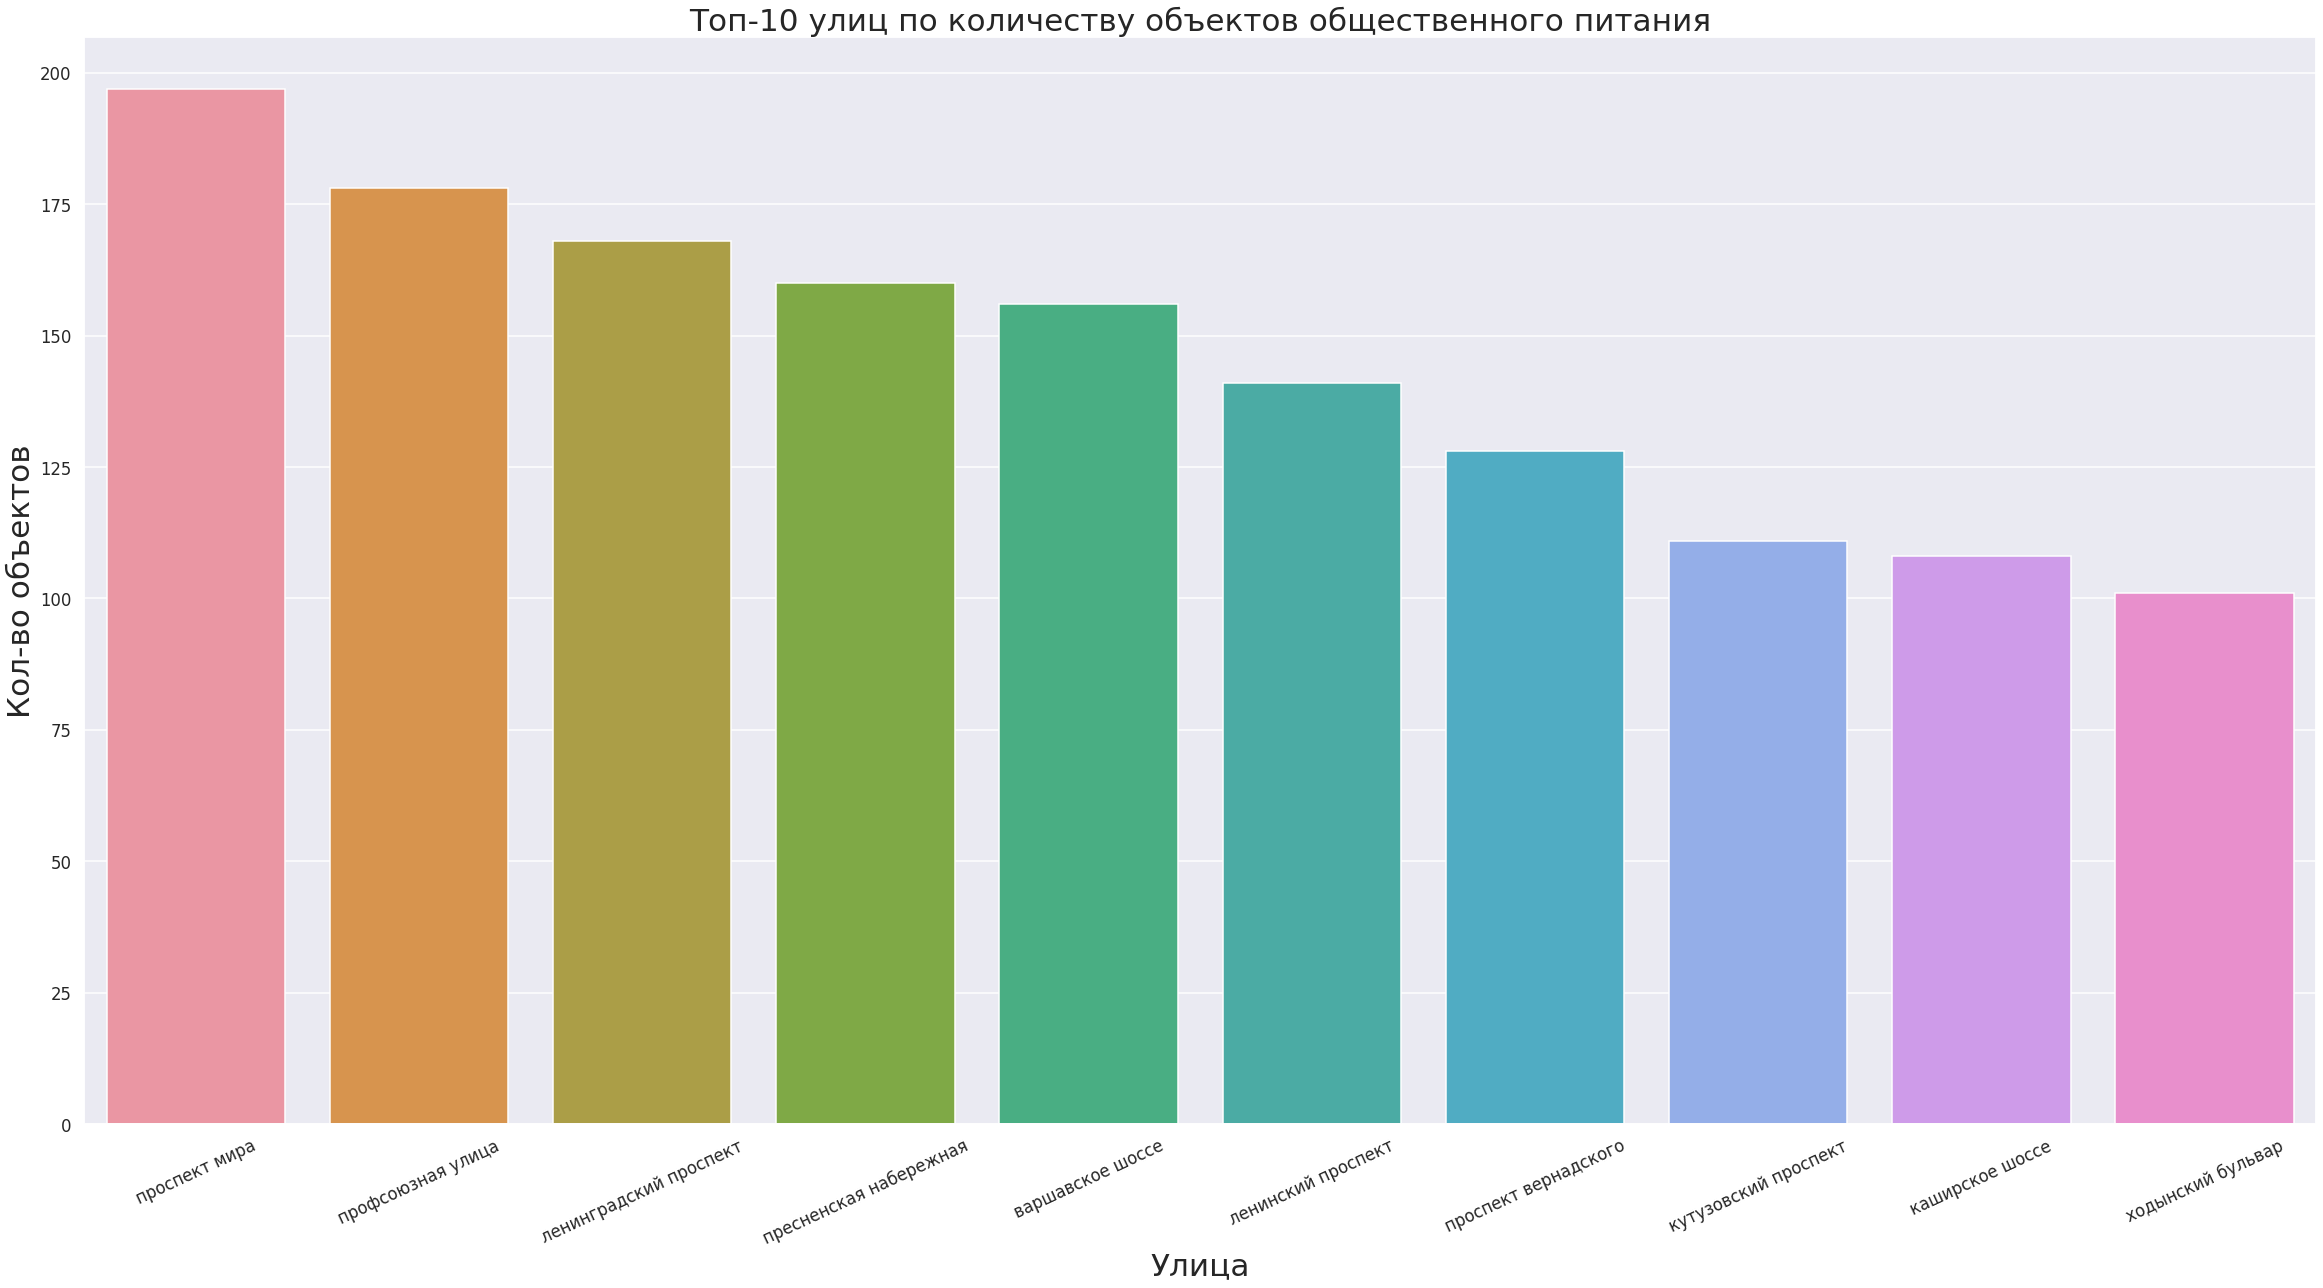

In [64]:
top10 = streets.head(10).reset_index()

plt.figure(figsize=(40,20))
sns.barplot(x='street', y='id', data=top10)
plt.title('Топ-10 улиц по количеству объектов общественного питания', size='xx-large')
plt.xlabel('Улица', size='xx-large')
plt.ylabel('Кол-во объектов',  size='xx-large')
plt.xticks(rotation=25)
plt.show()

In [65]:
top10 = top10.merge(district, how='left', left_on='street', right_on='streetname')
okruga = top10.pivot_table(index=['street', 'area'])

okruga.sort_values(by='id',ascending=False)

areaid   id  number
street                 area                                                
проспект мира          Алексеевский район                   70  197    44.0
                       Мещанский район                      16  197    44.0
                       Останкинский район                   79  197    44.0
                       Район Марьина роща                   78  197    44.0
                       Район Ростокино                      81  197    44.0
                       Район Свиблово                       82  197    44.0
                       Ярославский Район                    86  197    44.0
профсоюзная улица      Район Теплый Стан                   131  178    24.0
                       Обручевский район                   129  178    24.0
                       Район Коньково                      126  178    24.0
                       Академический район                 123  178    24.0
                       Район Черемушки                     132  178    24.0
                       Район Ясенево                       134  178    24.0
ленинградский проспект Район Аэропорт                       54  168    40.0
                       Район Беговой                        55  168    40.0
                       Район Сокол                          66  168    40.0
                       Хорошевский район                    69  168    40.0
пресненская набережная Пресненский район                    17  160    25.5
варшавское шоссе       Район Южное Бутово                  133  156    26.0
                       Район Чертаново Южное               110  156    26.0
                       Район Чертаново Центральное         109  156    26.0
                       Район Чертаново Северное            108  156    26.0
                       Район Северное Бутово               130  156    26.0
                       Нагорный район                      104  156    26.0
                       Район Нагатино-Садовники            102  156    26.0
                       Донской район                        99  156    26.0
ленинский проспект     Район Теплый Стан                   131  141    42.0
                       Обручевский район                   129  141    42.0
                       Район Гагаринский                   124  141    42.0
                       Донской район                        99  141    42.0
                       Ломоносовский район                 128  141    42.0
                       Район Якиманка                       21  141    42.0
                       Район Тропарево-Никулино             47  141    42.0
                       Район Проспект Вернадского           44  141    42.0
проспект вернадского   Район Гагаринский                   124  128    40.0
                       Ломоносовский район                 128  128    40.0
                       Район Тропарево-Никулино             47  128    40.0
                       Район Раменки                        45  128    40.0
                       Район Проспект Вернадского           44  128    40.0
кутузовский проспект   Район Фили-Давыдково                 49  111    40.0
                       Район Дорогомилово                   38  111    40.0
каширское шоссе        Район Орехово-Борисово Южное        106  108    24.5
                       Район Орехово-Борисово Северное     105  108    24.5
                       Район Нагатино-Садовники            102  108    24.5
                       Район Москворечье-Сабурово          101  108    24.5
ходынский бульвар      Хорошевский район                    69  101    10.0

**Промежуточный вывод:** Определили топ 10 улиц и построили график. Кол-вом объектов на данных улицах от 108 до 197 заведений. Среднее кол-во посадочных мест от 24 до 60.

### Найдите число улиц с одним объектом общественного питания. Воспользуйтесь внешней информацией и ответьте на вопрос — в каких районах Москвы находятся эти улицы?

In [66]:
df = data.merge(district, how='left', left_on='street', right_on='streetname')

street_count = df.groupby(['street', 'okrug', 'area']).agg({'id':'count'})

one_object = street_count[street_count['id'] == 1]

one_object.head(10)

id
street                     okrug area                    
1-й балтийский переулок    САО   Район Аэропорт         1
1-й басманный переулок     ЦАО   Басманный район        1
                                 Красносельский район   1
1-й ботанический проезд    СВАО  Район Свиблово         1
1-й вешняковский проезд    ЮВАО  Рязанский район        1
1-й голутвинский переулок  ЦАО   Район Якиманка         1
1-й зачатьевский переулок  ЦАО   Район Хамовники        1
1-й кирпичный переулок     ВАО   Район Соколиная Гора   1
1-й кожевнический переулок ЮАО   Даниловский район      1
1-й кожуховский проезд     ЮАО   Даниловский район      1

In [67]:
print('В каких районах Москвы находятся эти улицы? -', one_object.reset_index()['okrug'].unique())

В каких районах Москвы находятся эти улицы? - ['САО' 'ЦАО' 'СВАО' 'ЮВАО' 'ВАО' 'ЮАО' 'ЗАО' 'СЗАО' 'ЮЗАО' 'Зеленоград']


In [68]:
print('Кол-во улиц с одним объектом:',len(one_object))

Кол-во улиц с одним объектом: 567


**Промежуточные выводы:** Кол-во улиц с одним объектом: 567. Данные улицы входят во все основыне округа: САО, ЦАО, СВАО, ЮВАО, ВАО, ЮАО, ЗАО, СЗАО, ЮЗАО, ЗелАО.

### Посмотрите на распределение количества посадочных мест для улиц с большим количеством объектов общественного питания. Какие закономерности можно выявить?

In [69]:
top10_list = top10['street'].to_list()
top10_area = top10['area'].to_list()

top10_number = df.query('street == @top10_list')
top10_number = top10_number.query('area == @top10_area')

top10_number.head()

,id,object_name,chain,object_type,address,number,street,streetname,areaid,okrug,area
227,155973,кафе «андерсон»,да,кафе,"город москва, варшавское шоссе, дом 2",150,варшавское шоссе,варшавское шоссе,109.0,ЮАО,Район Чертаново Центральное
228,155973,кафе «андерсон»,да,кафе,"город москва, варшавское шоссе, дом 2",150,варшавское шоссе,варшавское шоссе,108.0,ЮАО,Район Чертаново Северное
229,155973,кафе «андерсон»,да,кафе,"город москва, варшавское шоссе, дом 2",150,варшавское шоссе,варшавское шоссе,110.0,ЮАО,Район Чертаново Южное
230,155973,кафе «андерсон»,да,кафе,"город москва, варшавское шоссе, дом 2",150,варшавское шоссе,варшавское шоссе,99.0,ЮАО,Донской район
231,155973,кафе «андерсон»,да,кафе,"город москва, варшавское шоссе, дом 2",150,варшавское шоссе,варшавское шоссе,102.0,ЮАО,Район Нагатино-Садовники


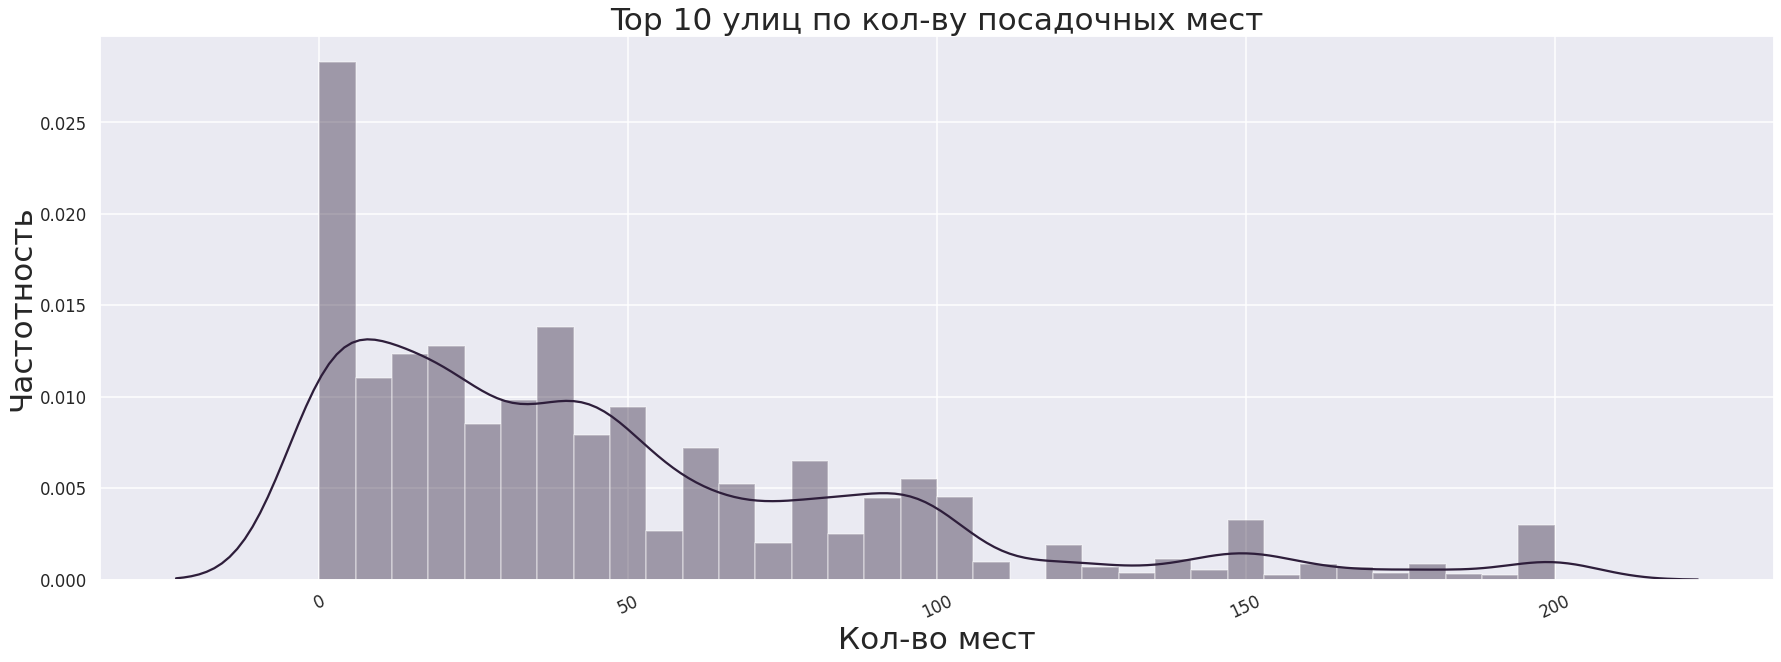

In [70]:
plt.figure(figsize=(30,10))
sns.distplot(top10_number['number'])
plt.title('Top 10 улиц по кол-ву посадочных мест', size='xx-large')
plt.xlabel('Кол-во мест', size='xx-large')
plt.ylabel('Частотность',  size='xx-large')
plt.xticks(rotation=25)
plt.show()

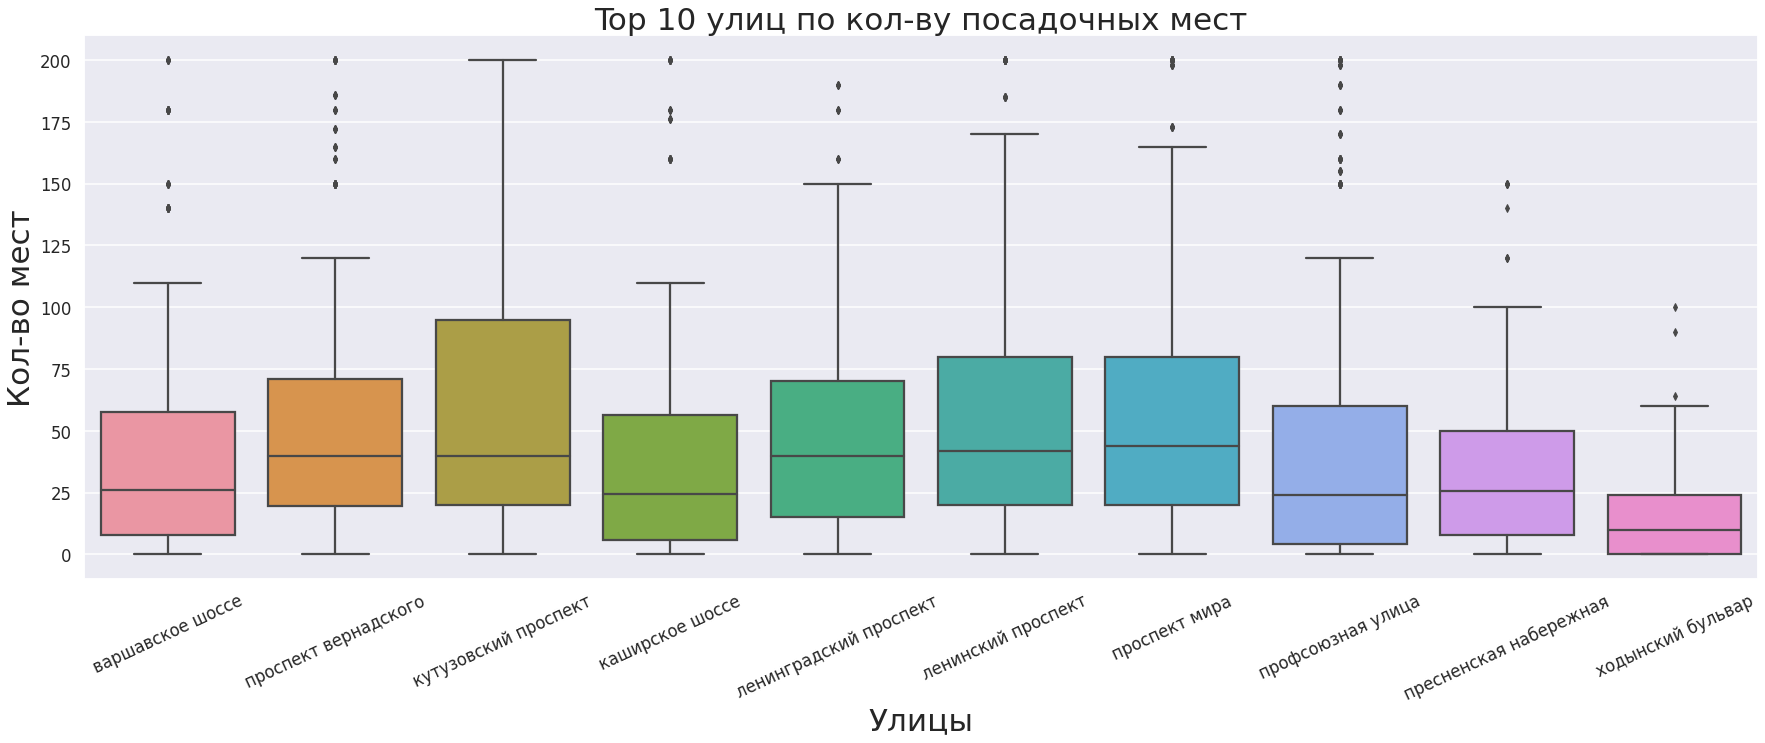

In [71]:
plt.figure(figsize=(30,10))
sns.boxplot(x='street', y='number', data=top10_number)
plt.title('Top 10 улиц по кол-ву посадочных мест', size='xx-large')
plt.xlabel('Улицы', size='xx-large')
plt.ylabel('Кол-во мест',  size='xx-large')
plt.xticks(rotation=25)
plt.show()

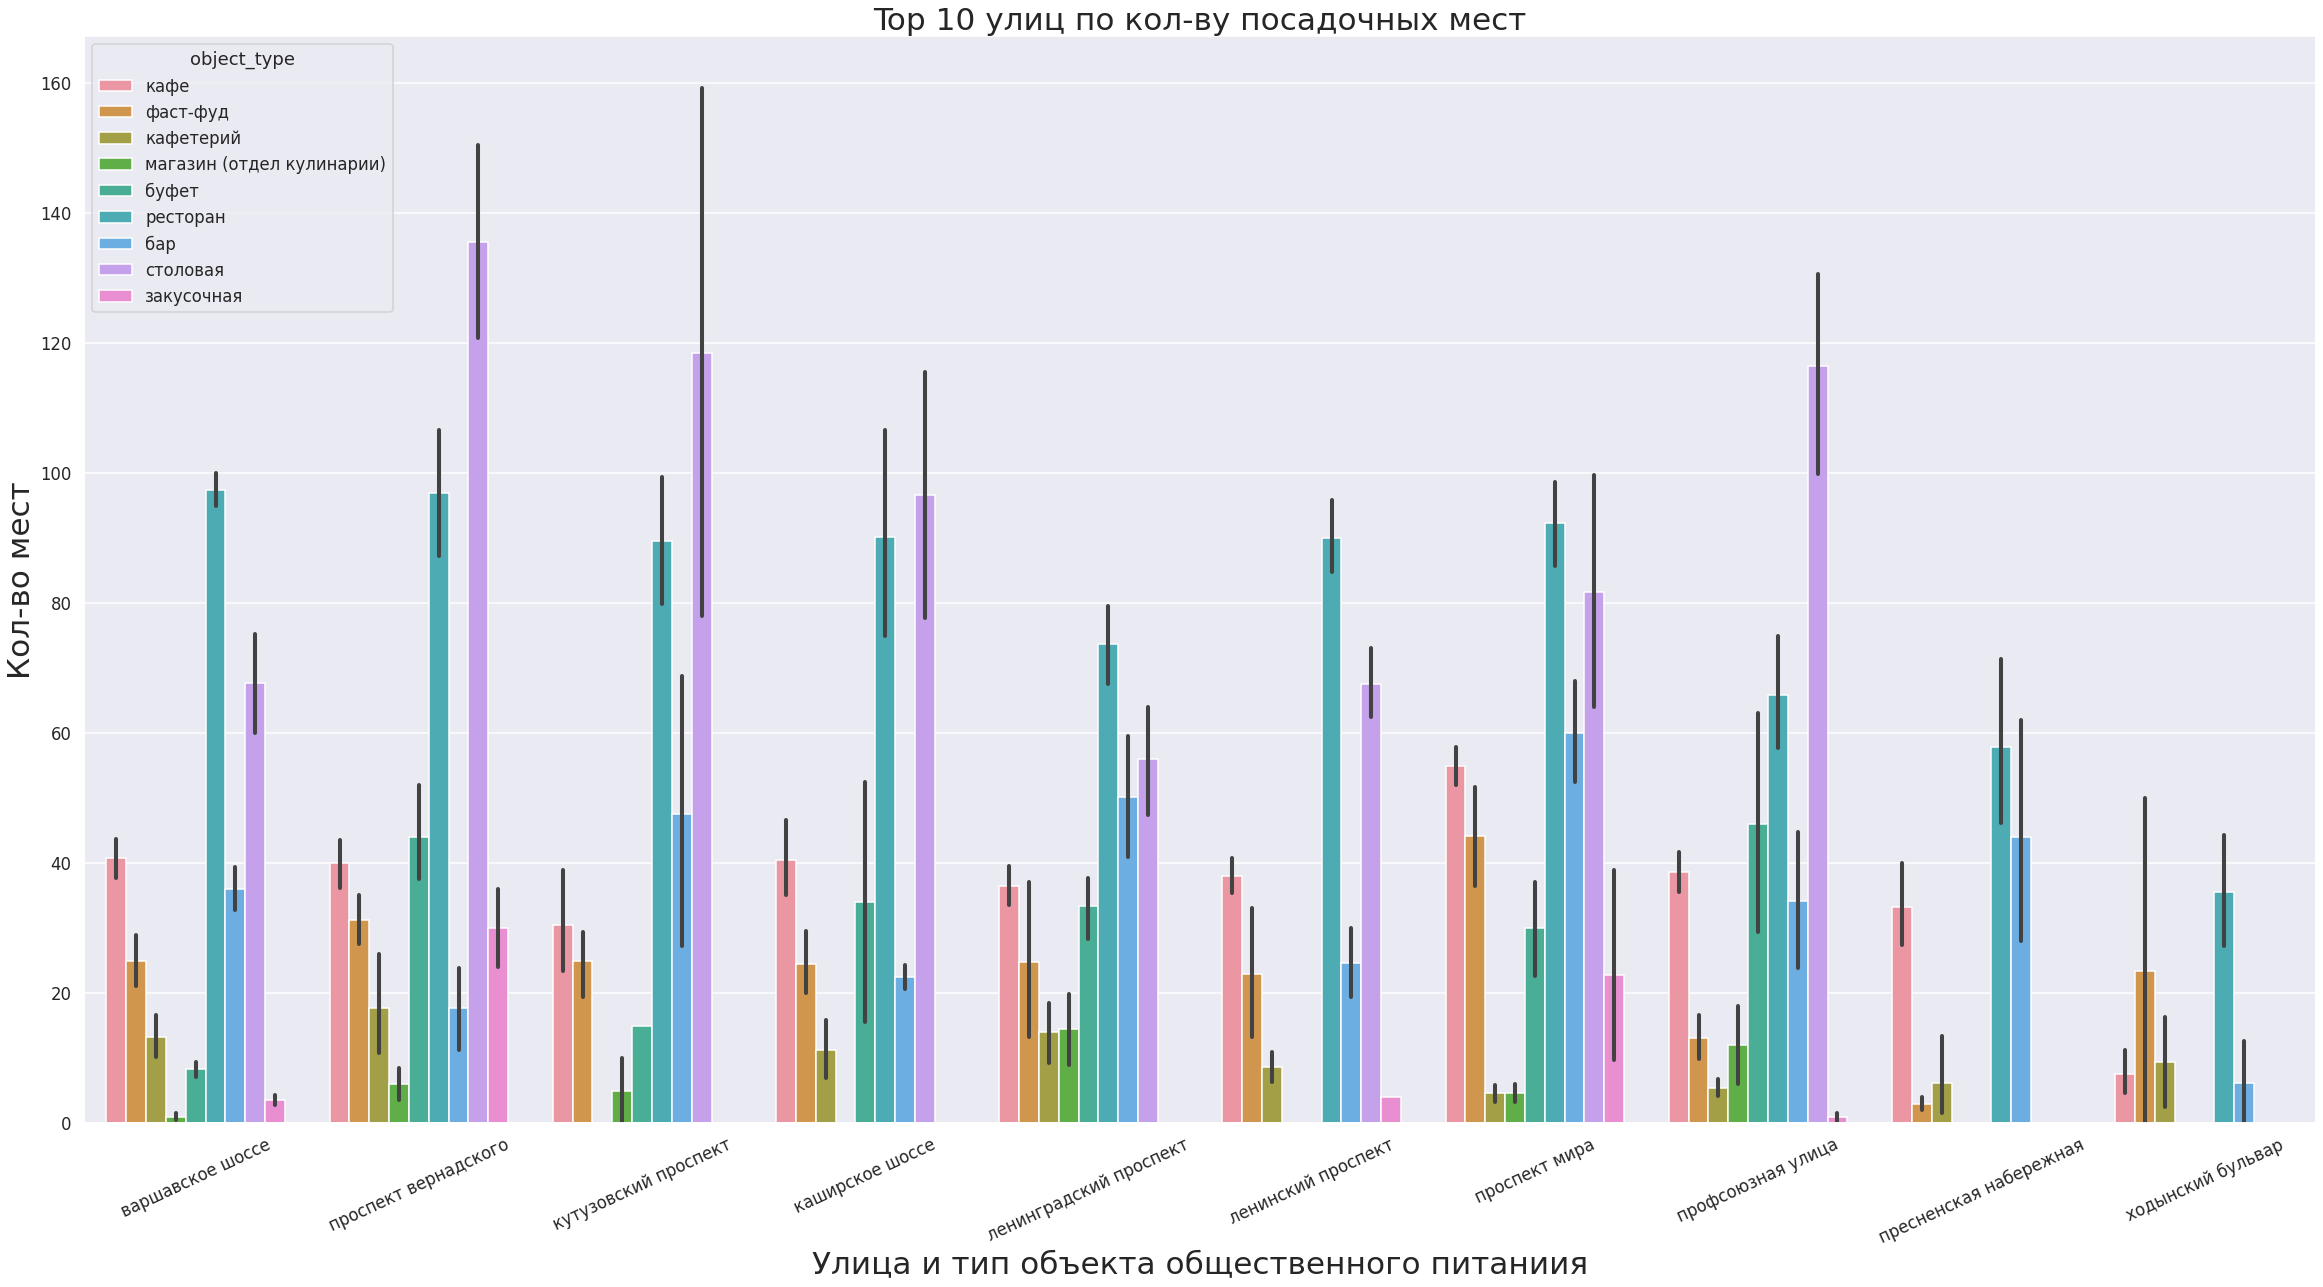

In [72]:
plt.figure(figsize=(40,20))
sns.barplot(x='street', y='number', data=top10_number, hue='object_type')
plt.title('Top 10 улиц по кол-ву посадочных мест', size='xx-large')
plt.xlabel('Улица и тип объекта общественного питаниия', size='xx-large')
plt.ylabel('Кол-во мест',  size='xx-large')
plt.xticks(rotation=25)
plt.show()

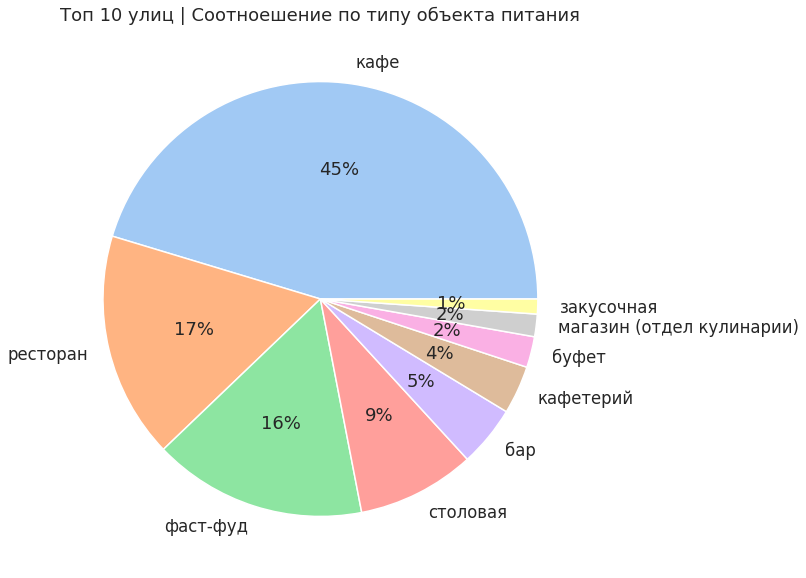

In [73]:
labels = top10_number['object_type'].value_counts().index
values = top10_number['object_type'].value_counts().to_list()

colors = sns.color_palette('pastel')

# create pie chart using matplotlib
plt.figure(figsize=(10,10))
plt.title('Топ 10 улиц | Соотноешение по типу объекта питания')
plt.pie(values, labels=labels, colors=colors, autopct='%.0f%%')
plt.show()

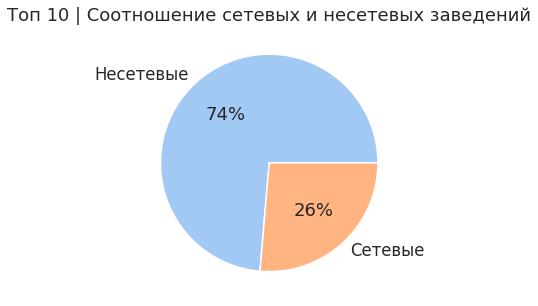

In [74]:
labels = ['Несетевые', 'Сетевые']
values = top10_number['chain'].value_counts()
colors = sns.color_palette('pastel')

# create pie chart using matplotlib
plt.figure(figsize=(10,5))
plt.title('Топ 10 | Соотношение сетевых и несетевых заведений')
plt.pie(values, labels=labels, colors=colors, autopct='%.0f%%')
plt.show()

In [75]:
print('Всего заведений в топ 10:', len(top10_number))
print('Кол-во заведений в топ 10 улицах без посадочных мест:',
      len(top10_number[top10_number['number'] == 0]))

Всего заведений в топ 10: 7050
Кол-во заведений в топ 10 улицах без посадочных мест: 784


In [76]:
top10_number.groupby('street')['number'].describe()

,count,mean,std,min,25%,50%,75%,max
street,,,,,,,,
варшавское шоссе,1248.0,38.692308,39.966885,0.0,8.00,26.0,57.75,200.0
каширское шоссе,432.0,42.416667,48.826246,0.0,6.00,24.5,56.25,200.0
кутузовский проспект,222.0,58.936937,53.602742,0.0,20.00,40.0,95.00,200.0
ленинградский проспект,672.0,46.744048,38.746376,0.0,15.00,40.0,70.00,190.0
ленинский проспект,1128.0,53.368794,43.984899,0.0,20.00,42.0,80.00,200.0
пресненская набережная,160.0,34.756250,34.646053,0.0,7.75,25.5,50.00,150.0
проспект вернадского,640.0,52.609375,48.173401,0.0,19.75,40.0,71.00,200.0
проспект мира,1379.0,55.827411,46.596459,0.0,20.00,44.0,80.00,200.0
профсоюзная улица,1068.0,42.342697,49.503293,0.0,4.00,24.0,60.00,200.0


**Промежуточный вывод:** 

- Всего заведений в топ 10: 7 050, это примерно половина от полченных нами данных.
- Кол-во заведений в топ 10 улицах без посадочных мест: 746

- Видим, что большинство заведений на этих улицах имеет примерно одинаковое кол-во посадочных мест примерно от 20 до 50. Сильно выделяется Кутузовский проспект. Примерно, одинаковые медианы значения у Варшавское Шоссе, Каширское Шоссе, Профсоюзная улица, Пресненская набережная. Также, похожи между собой распределения у Ленинский проспект, проспект Мира.

- Также на этих улицах сохраняется основная картина соотношения объектов общественного питания: Кафе — 45%, Ресторан — 17%, Фаст-фуд — 16%. У остальных объектов меньше 9%.

- Сетевые предприятий в топ 10 улицах составляют 26%.

## Вывод

На рынке общественного питания преобладают Кафе — 42% (6055 заведения), далее Ресторан — 15% (2128), Столовая» — 14% (2027), Фаст-фуд — 13%, а  остальные виды объектов ниже 6%.
Среди них всего 20% сетевых заведений, большинство 80% несетевых.

Большую долю в сетевых заведениях составляют заведения Фаст-фуд — 40%, далее Магазин (кулинария) — 28%, Ресторан — 23%, Бар— 22%.

Для несетевых заведений большую долю составляют Столовые и Буфеты. 

Как в случае с сетевыми, так и в случае с несетевыми, характерны общие черты — много заведений с относительно маленьким кол-вом мест до 60 посадочных мест. В случае несетевых заведений стоит отметить влияние Столовых, у которых в среднем 123 посадочных места.

Также, мы определили топ 10 улиц. Всего на них расположенно 7 050 заведения. Кол-вом объектов, разных типов, на данных улицах от 108 до 197 заведений. Среднее кол-во посадочных мест от 24 до 60. 
На этих улицах сохраняется основная картина соотношения объектов общественного питания: Кафе — 45%, Ресторан — 17%, Фаст-фуд — 16%. У остальных объектов меньше 9%. Сетевые предприятий в топ 10 улицах составляют 26%.

**Список топ 10 улиц:**
- проспект мира
- профсоюзная улица
- ленинградский проспект
- пресненская набережная
- варшавское шоссе
- ленинский проспект
- проспект вернадского
- кутузовский проспект
- каширское шоссе
- ходынский бульвар


**Рекомендации:**
Открыть Кафе с небольшим кол-вом мест (для начала до 30) с уклоном на быстрое обслуживание. Также, хочется отметить типы объектов Фаст-фуд и рестораны, как альтернативы. Локацию выбрать по возможности из топ три улиц: проспект мира, профсоюзная улица, ленинградский проспект, так как там уже большое кол-во заведений, а значит большая проходимость. 
Хочется отметить, что для более точной рекомендации хотелось бы иметь данные о среднем чеке и продолжительности жизни заведений.

## Презентация

- Презентация: <https://disk.yandex.ru/i/F_yzTYqZL0qjKw>